In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap
from sklearn import linear_model
from scipy import stats
from matplotlib.patches import Polygon

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
import os

In [2]:
print("pandas version : "+pd.__version__)
print("numpy version : "+np.__version__)
print("xarray version : "+xr.__version__)

pandas version : 1.4.3
numpy version : 1.20.2
xarray version : 0.18.2


In [4]:
def calc_corr_pval_nan(x_array,y_array):
    ma_x_array = np.ma.masked_invalid(x_array)
    ma_y_array = np.ma.masked_invalid(y_array)
    msk_x_y    = (~ma_x_array.mask & ~ma_y_array.mask)
    
    corr, pval  = stats.pearsonr(ma_x_array[msk_x_y],ma_y_array[msk_x_y])
    
    return corr, pval

In [5]:
def calc_lin_regline(x_array,y_array):
    reg = linear_model.LinearRegression()
    reg.fit(x_array,y_array)
    
    xp = np.linspace(np.min(x_array),np.max(x_array),100)
    yp = reg.coef_*xp + reg.intercept_
    
    return xp,yp

In [6]:
def plot_scat_regline(x_array,y_array,label_name,face_color,regline,axes):    
    ma_x_array = np.ma.masked_invalid(x_array)
    ma_y_array = np.ma.masked_invalid(y_array)
    msk_x_y    = (~ma_x_array.mask & ~ma_y_array.mask)
    
    xp, yp = calc_lin_regline(x_array[msk_x_y].values.reshape(-1,1),
                              y_array[msk_x_y].values.reshape(-1,1) ) 
    
    filled_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    color_name     = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
                      'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    
    for it in range(len(label_name)):
        marker_ind_tmp = np.mod(it,len(filled_markers))
        color_ind_tmp  = np.mod(it,len(color_name))
        
        if (face_color != 'none'): face_color = color_name[color_ind_tmp]
        axes.scatter(x_array[it],y_array[it],
                    marker=filled_markers[it],s=100,facecolors=face_color,
                    edgecolors=color_name[color_ind_tmp],label=label_name[marker_ind_tmp])

    if (regline): axes.plot(xp,yp.T,'-k',linewidth=2)

In [7]:
def mean_weighted_latlon(var):
    
    weights      = np.cos(np.deg2rad(var.lat))
    weights.name = "weights"    
    var_weighted = var.weighted(weights).mean(("lat","lon"))
    
    return var_weighted

In [8]:
def calc_PDF_EC(tmp_x,tmp_y,x,y):
    ## Emergent Constraint Method (Cox et al 2013)
    xn = tmp_x.values
    yn = tmp_y.values

    N = len(xn)
    sigma_x  = np.sqrt(np.var(xn))
    sigma_xy = np.sqrt(np.cov(xn,yn))[0,1]

    b = (sigma_xy/sigma_x)**2
    a = -1/N*(b*xn-yn).sum()

    fn = a + b*xn
    
    ## prediction error
    s = np.sqrt(1/(N-2)*((yn-fn)**2).sum())

    sigma_b = (s/sigma_x) * np.sqrt(N)
    sigma_fx = s * np.sqrt(1 + 1/N + (x-xn.mean())**2/(N*sigma_x**2))

    PDF_yx = 1/np.sqrt(2*np.pi*sigma_fx**2) * np.exp(-(y-(a+b*x))**2/(2*sigma_fx**2))

    return PDF_yx,sigma_fx, a+b*x

In [9]:
def make_lat_lon_box(lat_lon):
    
    control_latS  =  lat_lon[0][0]
    control_latN  =  lat_lon[0][1]
    control_lonL  =  lat_lon[1][0]
    control_lonR  =  lat_lon[1][1]
    
    N_latlon = 20
    lat_tmp1 = control_latS*np.ones(N_latlon)
    lat_tmp2 = control_latN*np.ones(N_latlon)

    lon_tmp1 = np.linspace(control_lonL,control_lonR,N_latlon)
    lon_tmp2 = np.linspace(control_lonR,control_lonL,N_latlon)

    lats = np.concatenate((lat_tmp1,lat_tmp2),axis=0)
    lons = np.concatenate((lon_tmp1,lon_tmp2),axis=0)
    
    return lats, lons

In [10]:
def draw_screen_poly( lats, lons, m, ax, color):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( list(xy), edgecolor=color, facecolor='none',
                              linewidth=1.25, alpha=0.65, linestyle='dotted' )
    ax.add_patch(poly)

## Range of Time,Lat,Lon in both model & observation 

In [11]:
latS = 66.5 ; latN = 90.
lonL = 0.  ; lonR = 360.

In [12]:
CMIP6_model_name  = ["ACCESS-ESM1-5", "CanESM5","CESM2","CESM2-WACCM","CNRM-ESM2-1", 
                     "GFDL-ESM4","IPSL-CM6A-LR","MIROC-ES2L", 
                     "MPI-ESM1-2-HR","MPI-ESM1-2-LR",
                     "NorESM2-LM","NorESM2-MM","UKESM1-0-LL"]

CMIP5_model_name  = ["CanESM2","CESM1-BGC",
                     "CNRM-CM5","GFDL-ESM2G","GFDL-ESM2M",
                     "GISS-E2-H-CC","GISS-E2-R-CC", 
                     "HadGEM2-CC","HadGEM2-ES","IPSL-CM5A-LR","IPSL-CM5A-MR", 
                     "MPI-ESM-LR","MPI-ESM-MR"]

## Read CMIP5 models area-averaged mean & delta 

#### 1) Read CHL Data

In [80]:
dir_name   =  "./DATA/CMIP5_Clim/CHL/"
file_name  =  "Delta_annual_CHL_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_CHL     = f["mean_hist"]
CMIP5_delta_ssp_126_CHL = f["delta_ssp126"]
CMIP5_delta_ssp_245_CHL = f["delta_ssp245"]
CMIP5_delta_ssp_585_CHL = f["delta_ssp585"]

#### 2) Read SIC Data

In [81]:
dir_name   =  "./DATA/CMIP5_Clim/SIC/"
file_name  =  "Delta_annual_SIC_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_SIC     = f["mean_hist"]
CMIP5_delta_ssp_126_SIC = f["delta_ssp126"]
CMIP5_delta_ssp_245_SIC = f["delta_ssp245"]
CMIP5_delta_ssp_585_SIC = f["delta_ssp585"]

#### 3) Read NO3 Data

In [82]:
dir_name   =  "./DATA/CMIP5_Clim/NO3/"
file_name  =  "Delta_annual_NO3_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_NO3     = f["mean_hist"]
CMIP5_delta_ssp_585_NO3 = f["delta_ssp585"]

#### 4) Read SST Data

In [83]:
dir_name   =  "./DATA/CMIP5_Clim/SST/"
file_name  =  "Delta_annual_SST_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_SST     = f["mean_hist"]
CMIP5_delta_ssp_585_SST = f["delta_ssp585"]

## Read CMIP6 models area-averaged mean & delta 

In [84]:
dir_name   =  "./DATA/CMIP5_Clim/PP/"
file_name  =  "Delta_annual_PP_CMIP5_Lat_6690.nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_PP     = f["mean_hist"]
CMIP5_delta_ssp_585_PP = f["delta_ssp585"]

In [85]:
dir_name   =  "./DATA/CMIP6_Clim/PP/"
file_name  =  "Delta_annual_PP_CMIP6_Lat_6690.nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_PP     = f["mean_hist"]
CMIP6_delta_ssp_585_PP = f["delta_ssp585"]

#### 1) Read CHL Data

In [86]:
dir_name   =  "./DATA/CMIP6_Clim/CHL/"
file_name  =  "Delta_annual_CHL_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_CHL     = f["mean_hist"]
CMIP6_delta_ssp_126_CHL = f["delta_ssp126"]
CMIP6_delta_ssp_245_CHL = f["delta_ssp245"]
CMIP6_delta_ssp_585_CHL = f["delta_ssp585"]

### 2) Read SIC Data

In [87]:
dir_name   =  "./DATA/CMIP6_Clim/SIC/"
file_name  =  "Delta_annual_SIC_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_SIC     = f["mean_hist"]
CMIP6_delta_ssp_126_SIC = f["delta_ssp126"]
CMIP6_delta_ssp_245_SIC = f["delta_ssp245"]
CMIP6_delta_ssp_585_SIC = f["delta_ssp585"]

#### 4) Read NO3 Data

In [88]:
dir_name   =  "./DATA/CMIP6_Clim/NO3/"
file_name  =  "Delta_annual_NO3_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_NO3     = f["mean_hist"]
CMIP6_delta_ssp_585_NO3 = f["delta_ssp585"]

In [89]:
dir_name   =  "./DATA/CMIP5_Clim/NO3/"
file_name  =  "Delta_annual_season_NO3_CMIP5_Lat_6690.nc"

path_name  =  dir_name+file_name
f          = xr.open_dataset(path_name)
CMIP5_mean_season_hist_NO3     = f["mean_hist"]


dir_name   =  "./DATA/CMIP6_Clim/NO3/"
file_name  =  "Delta_annual_season_NO3_CMIP6_Lat_6690.nc"

path_name  =  dir_name+file_name
f          = xr.open_dataset(path_name)
CMIP6_mean_season_hist_NO3     = f["mean_hist"]

In [21]:
### Constrain with summer nitrate
# CMIP5_mean_hist_NO3 = CMIP5_mean_season_hist_NO3[:,2]
# CMIP6_mean_hist_NO3 = CMIP6_mean_season_hist_NO3[:,2]

In [90]:
dir_name   =  "./DATA/CMIP6_Clim/SST/"
file_name  =  "Delta_annual_SST_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_SST     = f["mean_hist"]
CMIP6_delta_ssp_585_SST = f["delta_ssp585"]

### READ WOA18 DATA

In [106]:
## <Historical Experiment>
# dir_name   =  "./DATA/WOA13/Nitrate/"
# file_name  =  "woa13_all_n.lonflip.nc"

dir_name   =  "./DATA/WOA18/nitrate/"
file_name  =  "woa18_all_n00_01.nc"
path_name  =  dir_name+file_name
var_name   = "n_an"

f    = xr.open_dataset(path_name,decode_times=False)
depth_loc = f["depth"]

latS = 66.5 ; latN = 90;

NO3_WOA_loc    = f.sel(lat=slice(latS,latN))[var_name]
NO3_WOA_annual = NO3_WOA_loc[0,0,:,:]
NO3_WOA_mean   = mean_weighted_latlon(NO3_WOA_annual)

NO3_WOA_std    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).n_sd)[0,0]
NO3_WOA_err    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).n_se)[0,0]

In [107]:
def basemap_base(name_projection,latS,axes,lat,lon):
    m = Basemap(projection=name_projection,boundinglat=latS,lon_0=0,resolution='l',round=True,ax=axes)

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2,lat2)

    m.fillcontinents(color='grey',lake_color='gray',alpha=1.0)
    m.drawcoastlines(linewidth=0.4)
    m.drawmapboundary(fill_color='white')
    
    return m, x, y;

In [108]:
control_latS = 66.5 ;  control_latN = 66.5
control_lonL = 0     ;  control_lonR = 360

lat_lon_AO = np.array([[control_latS,control_latN],[control_lonL,control_lonR]])
lats_AO,lons_AO = make_lat_lon_box(lat_lon_AO)

In [122]:
### Spatial Correlation between standard deviation and standard error
tmp1 = f.sel(lat=slice(latS,latN)).n_sd[0,0].values.reshape(-1,1)
tmp2 = f.sel(lat=slice(latS,latN)).n_se[0,0].values.reshape(-1,1)

calc_corr_pval_nan(tmp1,tmp2)

(0.8370092806551017, 0.0)

<ipython-input-116-f48d4bf3043c>:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour_delta = m.pcolormesh(x,y,tmp_cont,cmap='jet',vmin=vmin,vmax=vmax)


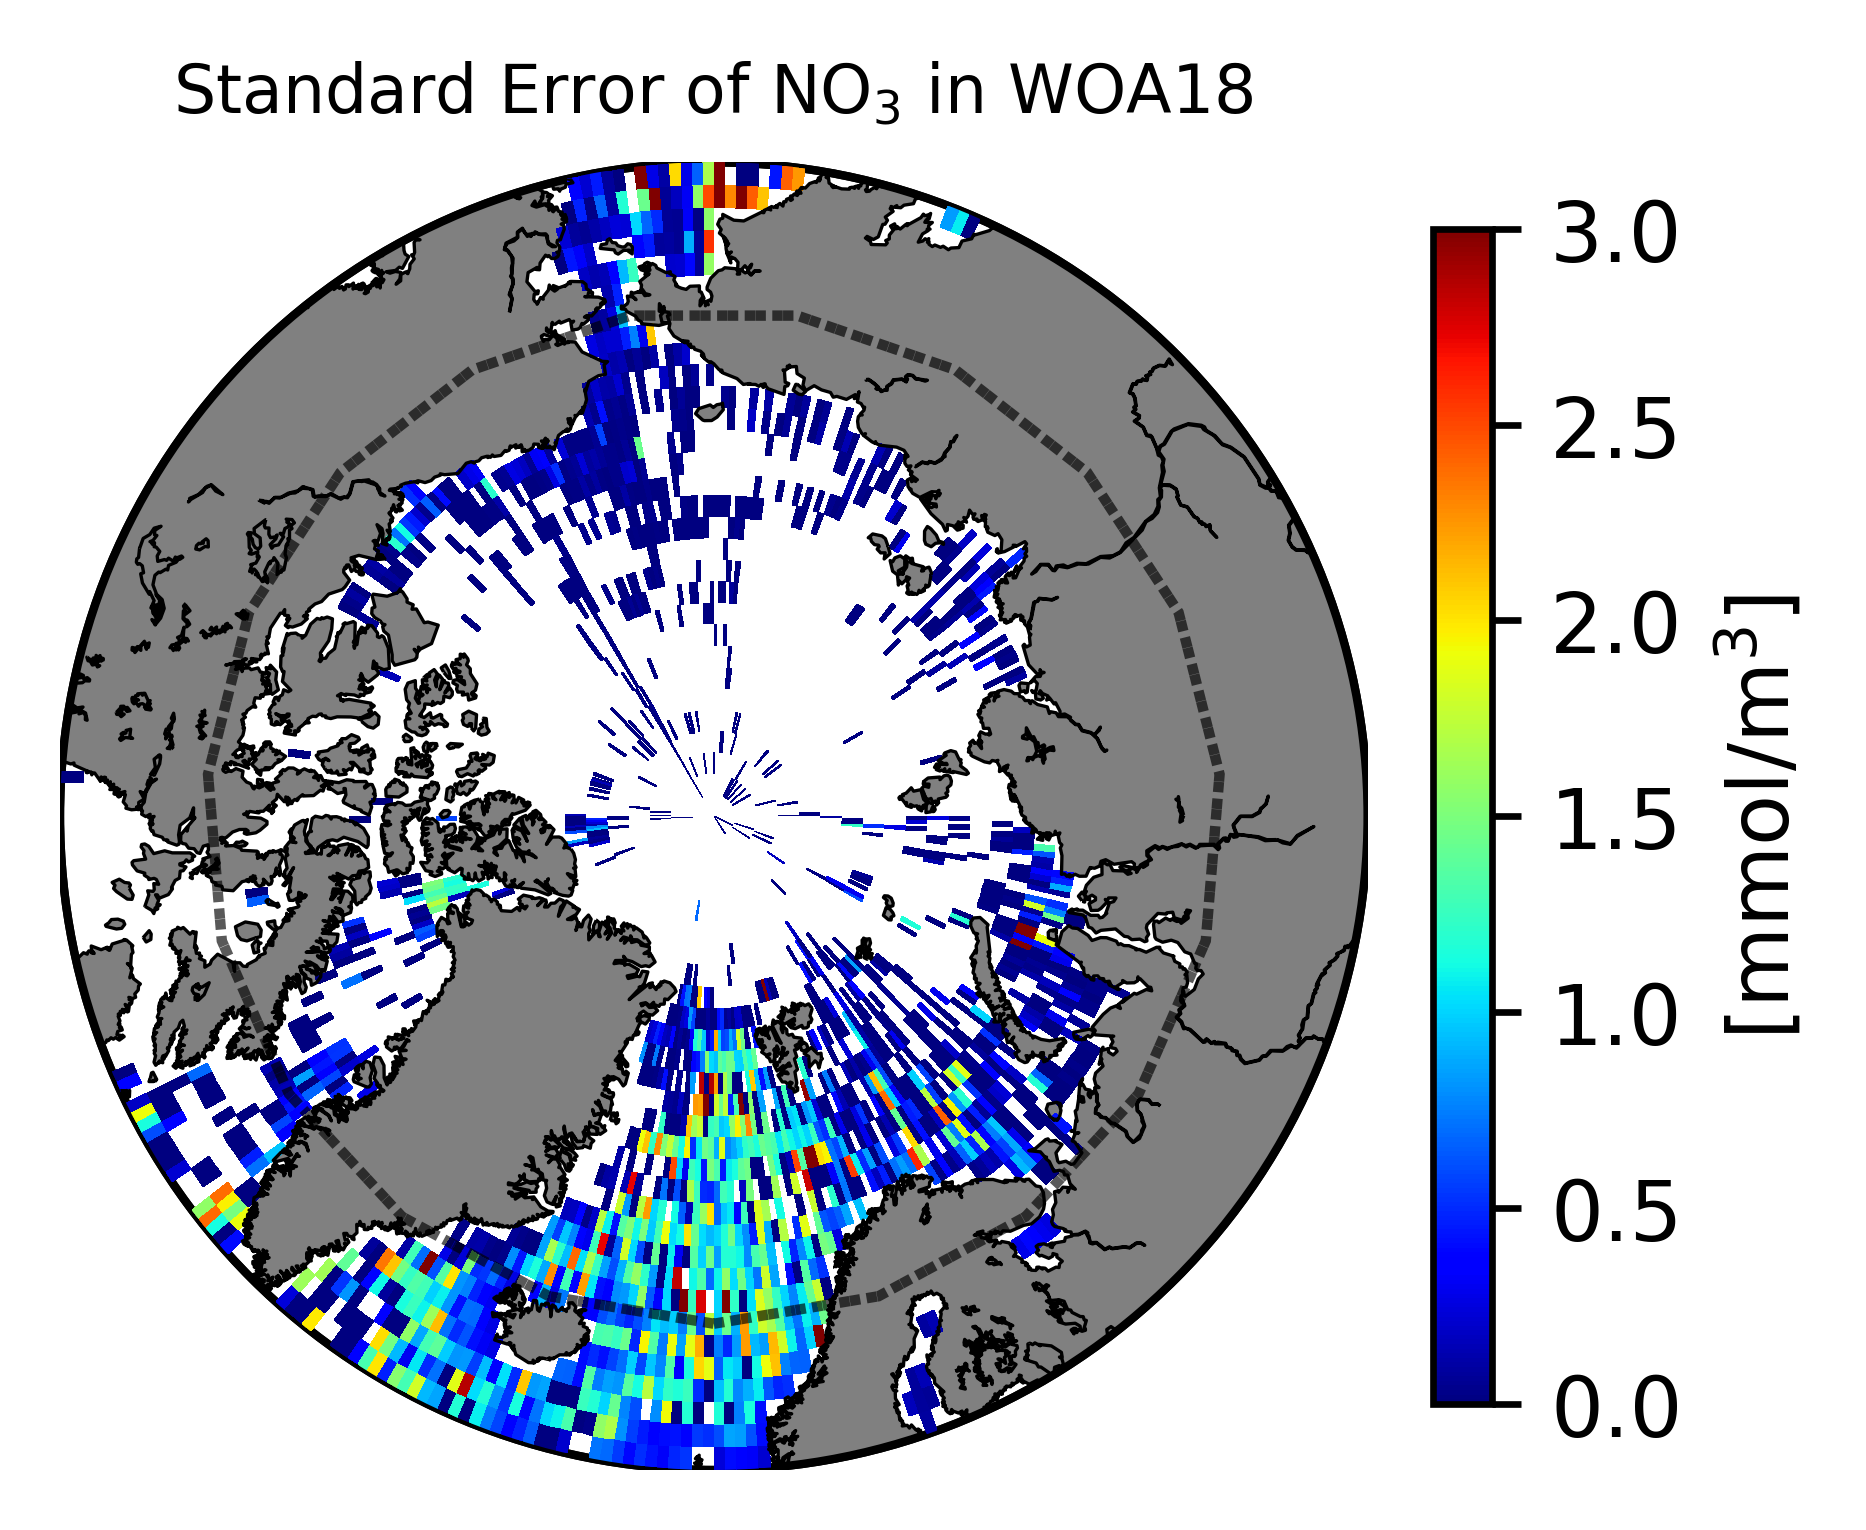

In [116]:
tmp_cont = f.sel(lat=slice(latS,latN)).n_se[0,0]

fig, axes = plt.subplots(1,1,figsize=(3,4), constrained_layout=True)
    
latS = 60

vmin      = 0  ; vmax      = 3
levels    = 50  ; level_boundaries = np.linspace(vmin,vmax,levels+1)
opacity   = 0.5

# ## <SSP585[2081-2100] - Historical Scenario[1981-2000]
# ## <Positive CHL Trend Models Compoosite>
m, x, y = basemap_base('npstere',latS,axes,f.lat.sel(lat=slice(latS,latN)),f.lon)
contour_delta = m.pcolormesh(x,y,tmp_cont,cmap='jet',vmin=vmin,vmax=vmax)
axes.set_title("Standard Error of NO$_3$ in WOA18",fontsize=8)
draw_screen_poly( lats_AO, lons_AO, m , axes, 'black')

cb = fig.colorbar(contour_delta,ax=axes,location='right', label="[mmol/m$^3$]",shrink=0.5)
# cb.set_ticks([-0.3, -0.15, 0., 0.15, 0.3])

dir_name    =  "./RESULT/"
title_name  =  "Contour_WOA18_NO3_ERROR.pdf"
path_name   =  dir_name+title_name
    
plt.savefig(path_name)

### READ GLODAP DATA

In [93]:
## <Historical Experiment>

dir_name   =  "./DATA/GLODAPv2/"
file_name  =  "GLODAPv2.nitrate.nc"
path_name  =  dir_name+file_name
var_name   = "nitrate"

f    = xr.open_dataset(path_name,decode_times=False)

NO3_GLODAP_loc    = f.sel(lat=slice(latS,latN))[var_name]
NO3_GLODAP_annual = NO3_GLODAP_loc[0,:,:]
NO3_GLODAP_mean   = mean_weighted_latlon(NO3_GLODAP_annual)

NO3_GLODAP_std    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).Input_std)[0]

## Emergent Constraint for Primary Production

In [94]:
def calc_GAUSSIAN_PDF(mu,sigma,x):
    
    PDF = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-1/2*((x-mu)/sigma)**2)
    
    return PDF

In [75]:
##########################################################################################
######                 Emergent Constraint Method (Cox et al 2013)
##########################################################################################
def calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_x):
    dx = x[1]-x[0]

    ### Inter-model Spread in CMIP Data
    xn = tmp_x.values
    yn = tmp_y.values
    
    ### Linear Regression for inter-model Diversity
    N = len(xn)
    sigma_x  = np.sqrt(np.var(xn))
    sigma_xy = np.sqrt(np.cov(xn,yn))[0,1]

    b = (sigma_xy/sigma_x)**2
    a = -1/N*(b*xn-yn).sum()

    fn = a + b*xn
    
    ### Prediction Error
    s        = np.sqrt(1/(N-2)*((yn-fn)**2).sum())
    sigma_b  = (s/sigma_x) * np.sqrt(N)

    ### Calculate PDF(y) [posteriori] by given PDF(y|x) [Priori] and PDF(x) [OBS]
    PDF_y = np.zeros(len(y))
    for ind_y in range(len(y)):
        for ind_x in range(len(x)):
            sigma_fx       = s * np.sqrt(1 + 1/N + (x[ind_x]-xn.mean())**2/(N*sigma_x**2))
            PDF_yx         = 1/np.sqrt(2*np.pi*sigma_fx**2) \
                           * np.exp(-(y[ind_y]-(a+b*x[ind_x]))**2/(2*sigma_fx**2))            
            PDF_y[ind_y] += PDF_yx * PDF_x[ind_x] * dx 
            
    thres     = 0.341 ###
    sigma_y   = find_std_from_PDF(thres,y,PDF_y)
    mean_y    = y[PDF_y.argmax()]
    
    return PDF_y, sigma_y, mean_y

In [27]:
def find_std_from_PDF(thres,y,PDF):
    ind_max = PDF.argmax()

    for ind_point in range(len(y)):
        PDF_sum = PDF[ind_point:ind_max+1].sum()/PDF.sum()
        if (PDF_sum < thres): 
            sigma = y[ind_max]-y[ind_point]
            break
        
    return sigma

In [28]:
def calc_PDF_EC_PRIOR(tmp_x,tmp_y,x,y):
    ## Emergent Constraint Method (Cox et al 2013)
    xn = tmp_x.values
    yn = tmp_y.values

    N = len(xn)
    sigma_x  = np.sqrt(np.var(xn))
    sigma_xy = np.sqrt(np.cov(xn,yn))[0,1]

    b = (sigma_xy/sigma_x)**2
    a = -1/N*(b*xn-yn).sum()

    fn = a + b*xn
    
    ## prediction error
    s = np.sqrt(1/(N-2)*((yn-fn)**2).sum())

    sigma_b = (s/sigma_x) * np.sqrt(N)
    sigma_fx = s * np.sqrt(1 + 1/N + (x-xn.mean())**2/(N*sigma_x**2))

    PDF_yx = 1/np.sqrt(2*np.pi*sigma_fx**2) * np.exp(-(y-(a+b*x))**2/(2*sigma_fx**2))

    return PDF_yx,sigma_fx, a+b*x

In [40]:
xn = tmp_x.values
yn = tmp_y.values

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


### Calculate NO3 PDF for WOA in the Arctic Ocean
mu_WOA              = NO3_WOA_mean.values
sigma_WOA           = NO3_WOA_std.values
PDF_WOA_NO3     = calc_GAUSSIAN_PDF(mu_WOA,sigma_WOA,x)

### Calculate NO3 PDF for GLODAP in the Arctic Ocean
mu_GLODAP              = NO3_GLODAP_mean.values
sigma_GLODAP           = NO3_GLODAP_std.values
PDF_GLODAP_NO3  = calc_GAUSSIAN_PDF(mu_GLODAP,sigma_GLODAP,x)

### Calculate Constrained CHL PDF with WOA, GLODAP Observation
PDF_WOA_CHL,    sigma_WOA_CHL,    mean_WOA_CHL    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP_CHL, sigma_GLODAP_CHL, mean_GLODAP_CHL = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)

28.144371081454032 34.4208461130178
6.533333333333331 20.53333333333333
2.8000000000000114 18.66666666666667


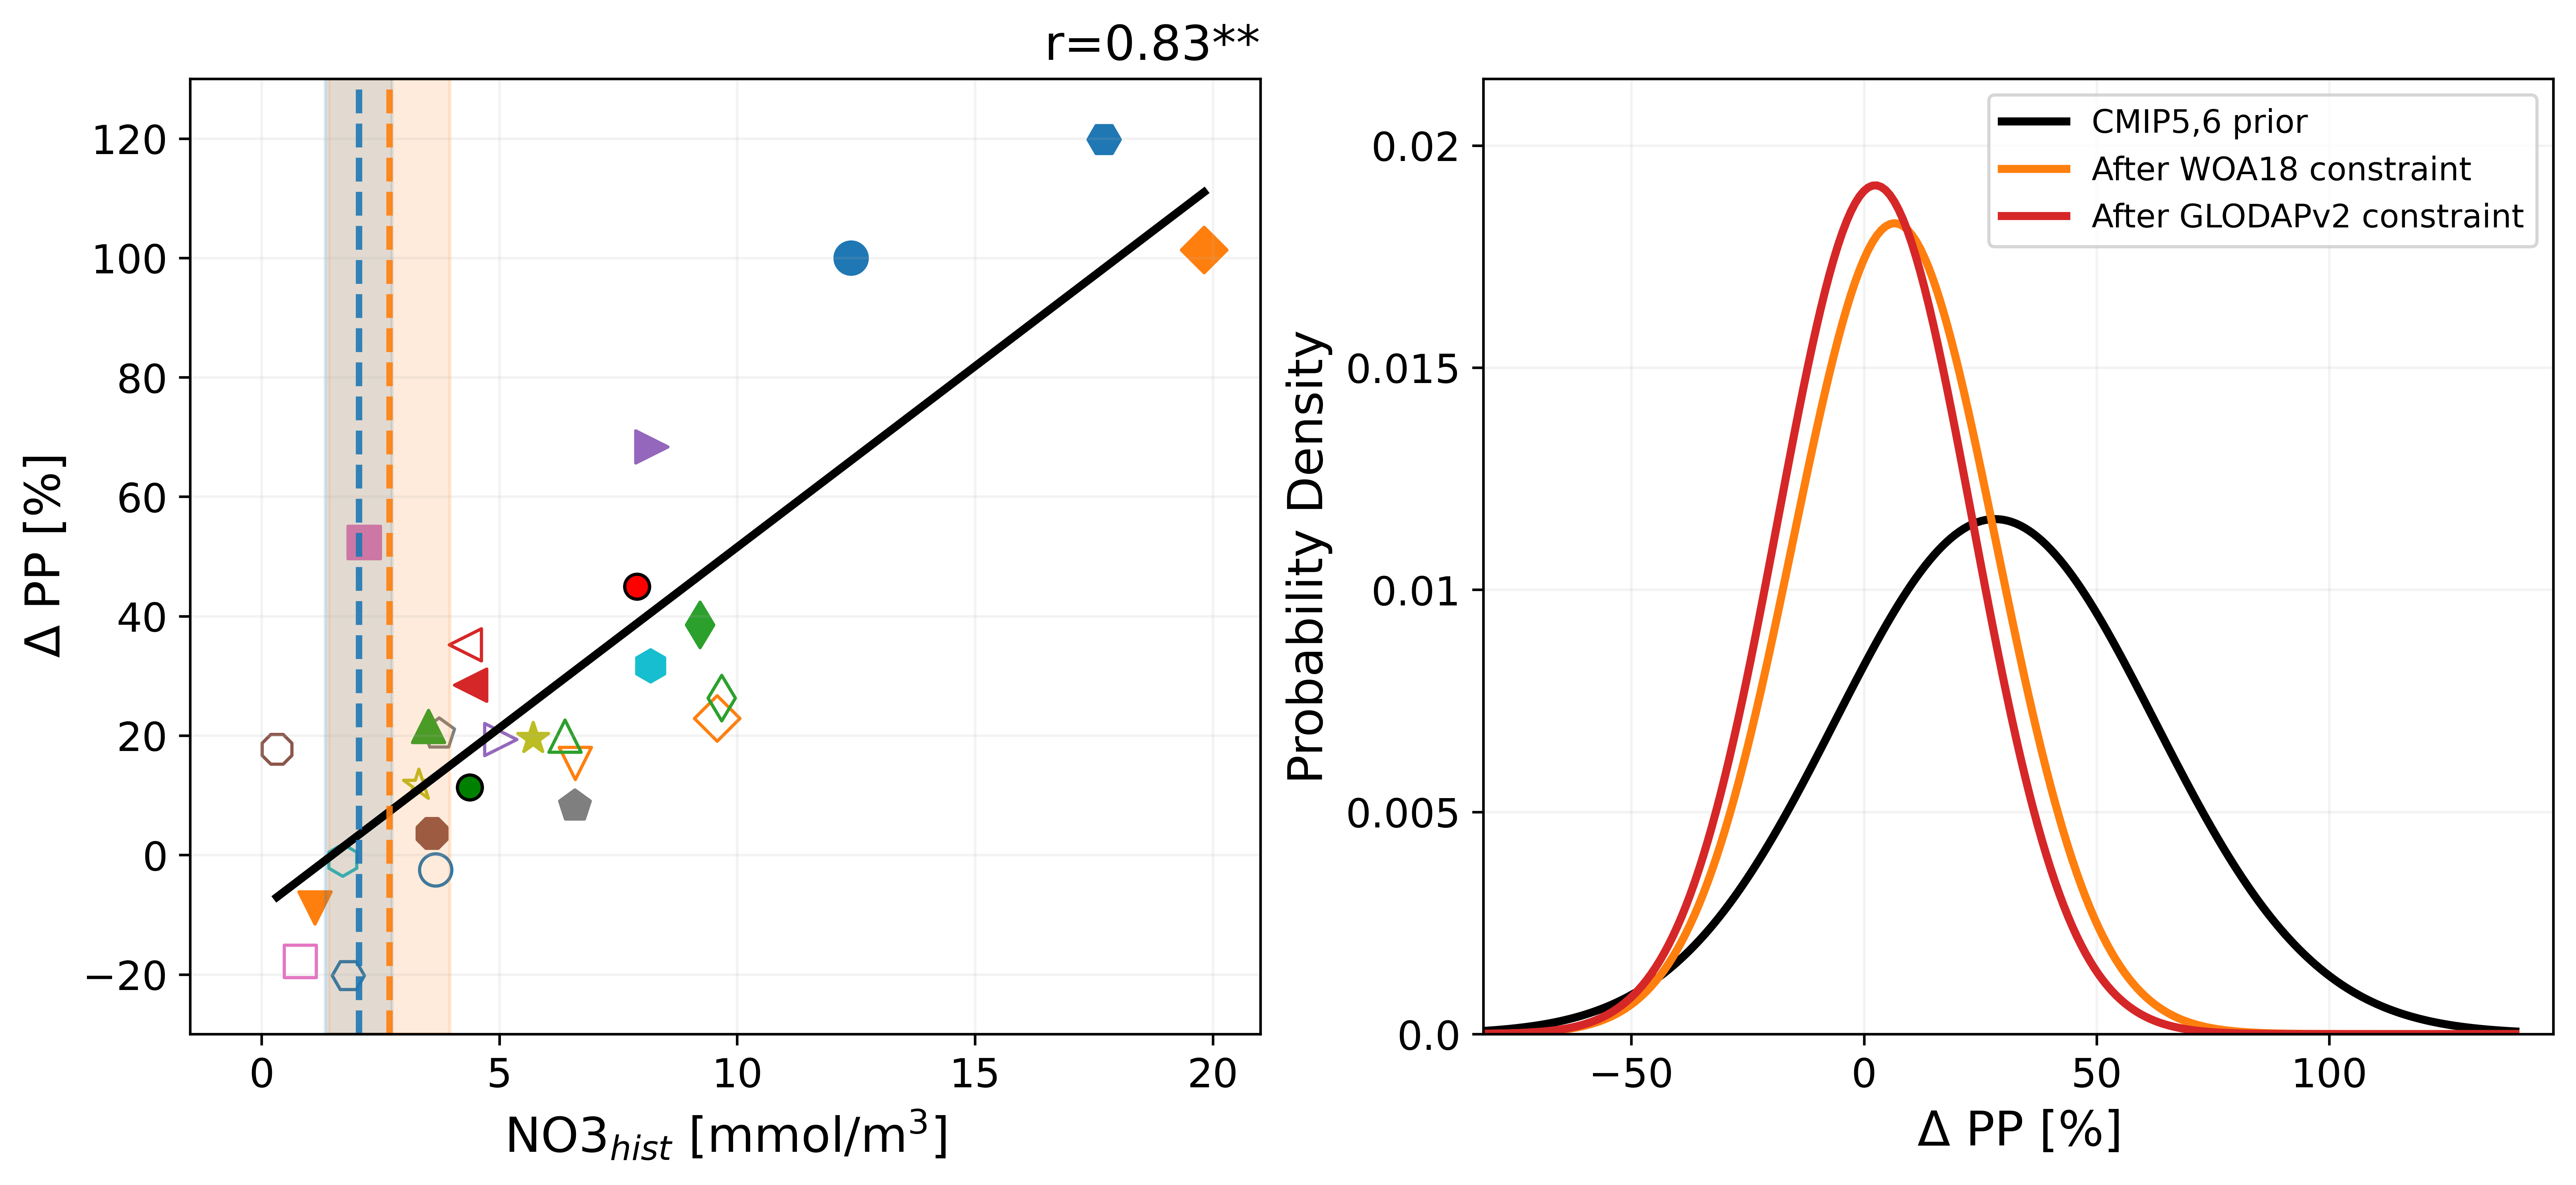

In [126]:
##########################################################################################
### Combine CMIP5 and CMIP6 Data to One array
##########################################################################################

tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3
tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_PP
tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_PP

tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

tmp_x = tmp_x[~np.isnan(tmp_y)]
tmp_y = tmp_y[~np.isnan(tmp_y)]

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


##########################################################################################
### Calculate NO3 PDF for WOA in the Arctic Ocean
##########################################################################################
mu_WOA_NO3        = NO3_WOA_mean.values
sigma_WOA_NO3     = NO3_WOA_std.values
PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


##########################################################################################
### Calculate NO3 PDF for GLODAP in the Arctic Ocean
##########################################################################################
mu_GLODAP_NO3     = NO3_GLODAP_mean.values
sigma_GLODAP_NO3  = NO3_GLODAP_std.values
PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


##########################################################################################
### Calculate Constrained CHL PDF with WOA, GLODAP Observation
##########################################################################################
PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


##########################################################################################
### Calculate CMIP meand and STD
##########################################################################################
tmp_mean = tmp_y.mean("model_name").values
tmp_std  = tmp_y.std("model_name").values

P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

print(tmp_mean,tmp_std)
print(mean_WOA,sigma_WOA)
print(mean_GLODAP,sigma_GLODAP)

fig, axes = plt.subplots(1,2,figsize=(11,5),constrained_layout=True)

##########################################################################################
### Scatter Plot for NO3_Hist and PP Difference
##########################################################################################
plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                  tmp_x_CMIP5.model_name.values,'none',False,axes[0])
plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                  tmp_x_CMIP6.model_name.values,'filled',False,axes[0])

axes[0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
axes[0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')


##########################################################################################
### Linear-Regression for NO3_Hist and PP Difference
##########################################################################################
xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                          tmp_y.values.reshape(-1,1))
tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

axes[0].plot(xp,yp.T,'k-',linewidth=2.5)


##########################################################################################
### Mean NO3 and its Uncertainty in WOA and GLODAP
##########################################################################################
axes[0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                color='tab:blue',alpha=0.15)
axes[0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                color='tab:orange',alpha=0.15)

axes[0].axvline(mu_GLODAP_NO3,
                linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
axes[0].axvline(mu_WOA_NO3,
                linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


##########################################################################################
### Constrained PDF of PP Projection in WOA and GLODAP
##########################################################################################
axes[1].plot(y,P,'k',linewidth=2.5,label="CMIP5,6 prior")
axes[1].plot(y,PDF_WOA,'tab:orange',linewidth=2.5,label="After WOA18 constraint")
axes[1].plot(y,PDF_GLODAP,'tab:red',linewidth=2.5,label="After GLODAPv2 constraint")


##########################################################################################
### Settings for Plots
##########################################################################################
axes[0].set_title("r={:4.2f}".format(tmp_corr)+"**",loc='right',fontsize=15)

axes[0].grid(alpha=0.15)
axes[0].set_xlim([-1.5,21]) 
axes[0].set_ylim([-30,130])  ## SSP5-85 [PP]


axes[1].set_xlim([tmp_mean-110,tmp_mean+120])
axes[1].grid(alpha=0.15)
axes[1].legend(fontsize=10)

axes[0].set_ylabel("$\Delta$ PP [%]",fontsize=15)
axes[0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
axes[1].set_xlabel("$\Delta$ PP [%]",fontsize=15)
axes[1].set_ylabel("Probability Density",fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)

axes[1].set_ylim([0.00,0.0215])
axes[1].set_yticks([0,0.005,0.01,0.015,0.02])
axes[1].set_yticklabels([0.00,0.005,0.010,0.015,0.02], fontsize=12.5)
# axes[1].axvline(0,color='k',linewidth=2,alpha=0.5)
# axes[1].axhline(0,color='k',linewidth=2,alpha=0.5,linestyle='--')

##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PDF_CMIP56_SSP585_PP_NO3_LAT"+str(latS)+str(latN)+".pdf"
plt.savefig(dir_name+file_name)

In [96]:
model_CMIP5 = CMIP5_mean_hist_NO3.model_name
model_CMIP6 = CMIP6_mean_hist_NO3.model_name

CMIP56 : -13.48 (48.76)
WOA Constrained : -44.80 (28.00)
GLODAP Constrained : -51.33 (26.13)


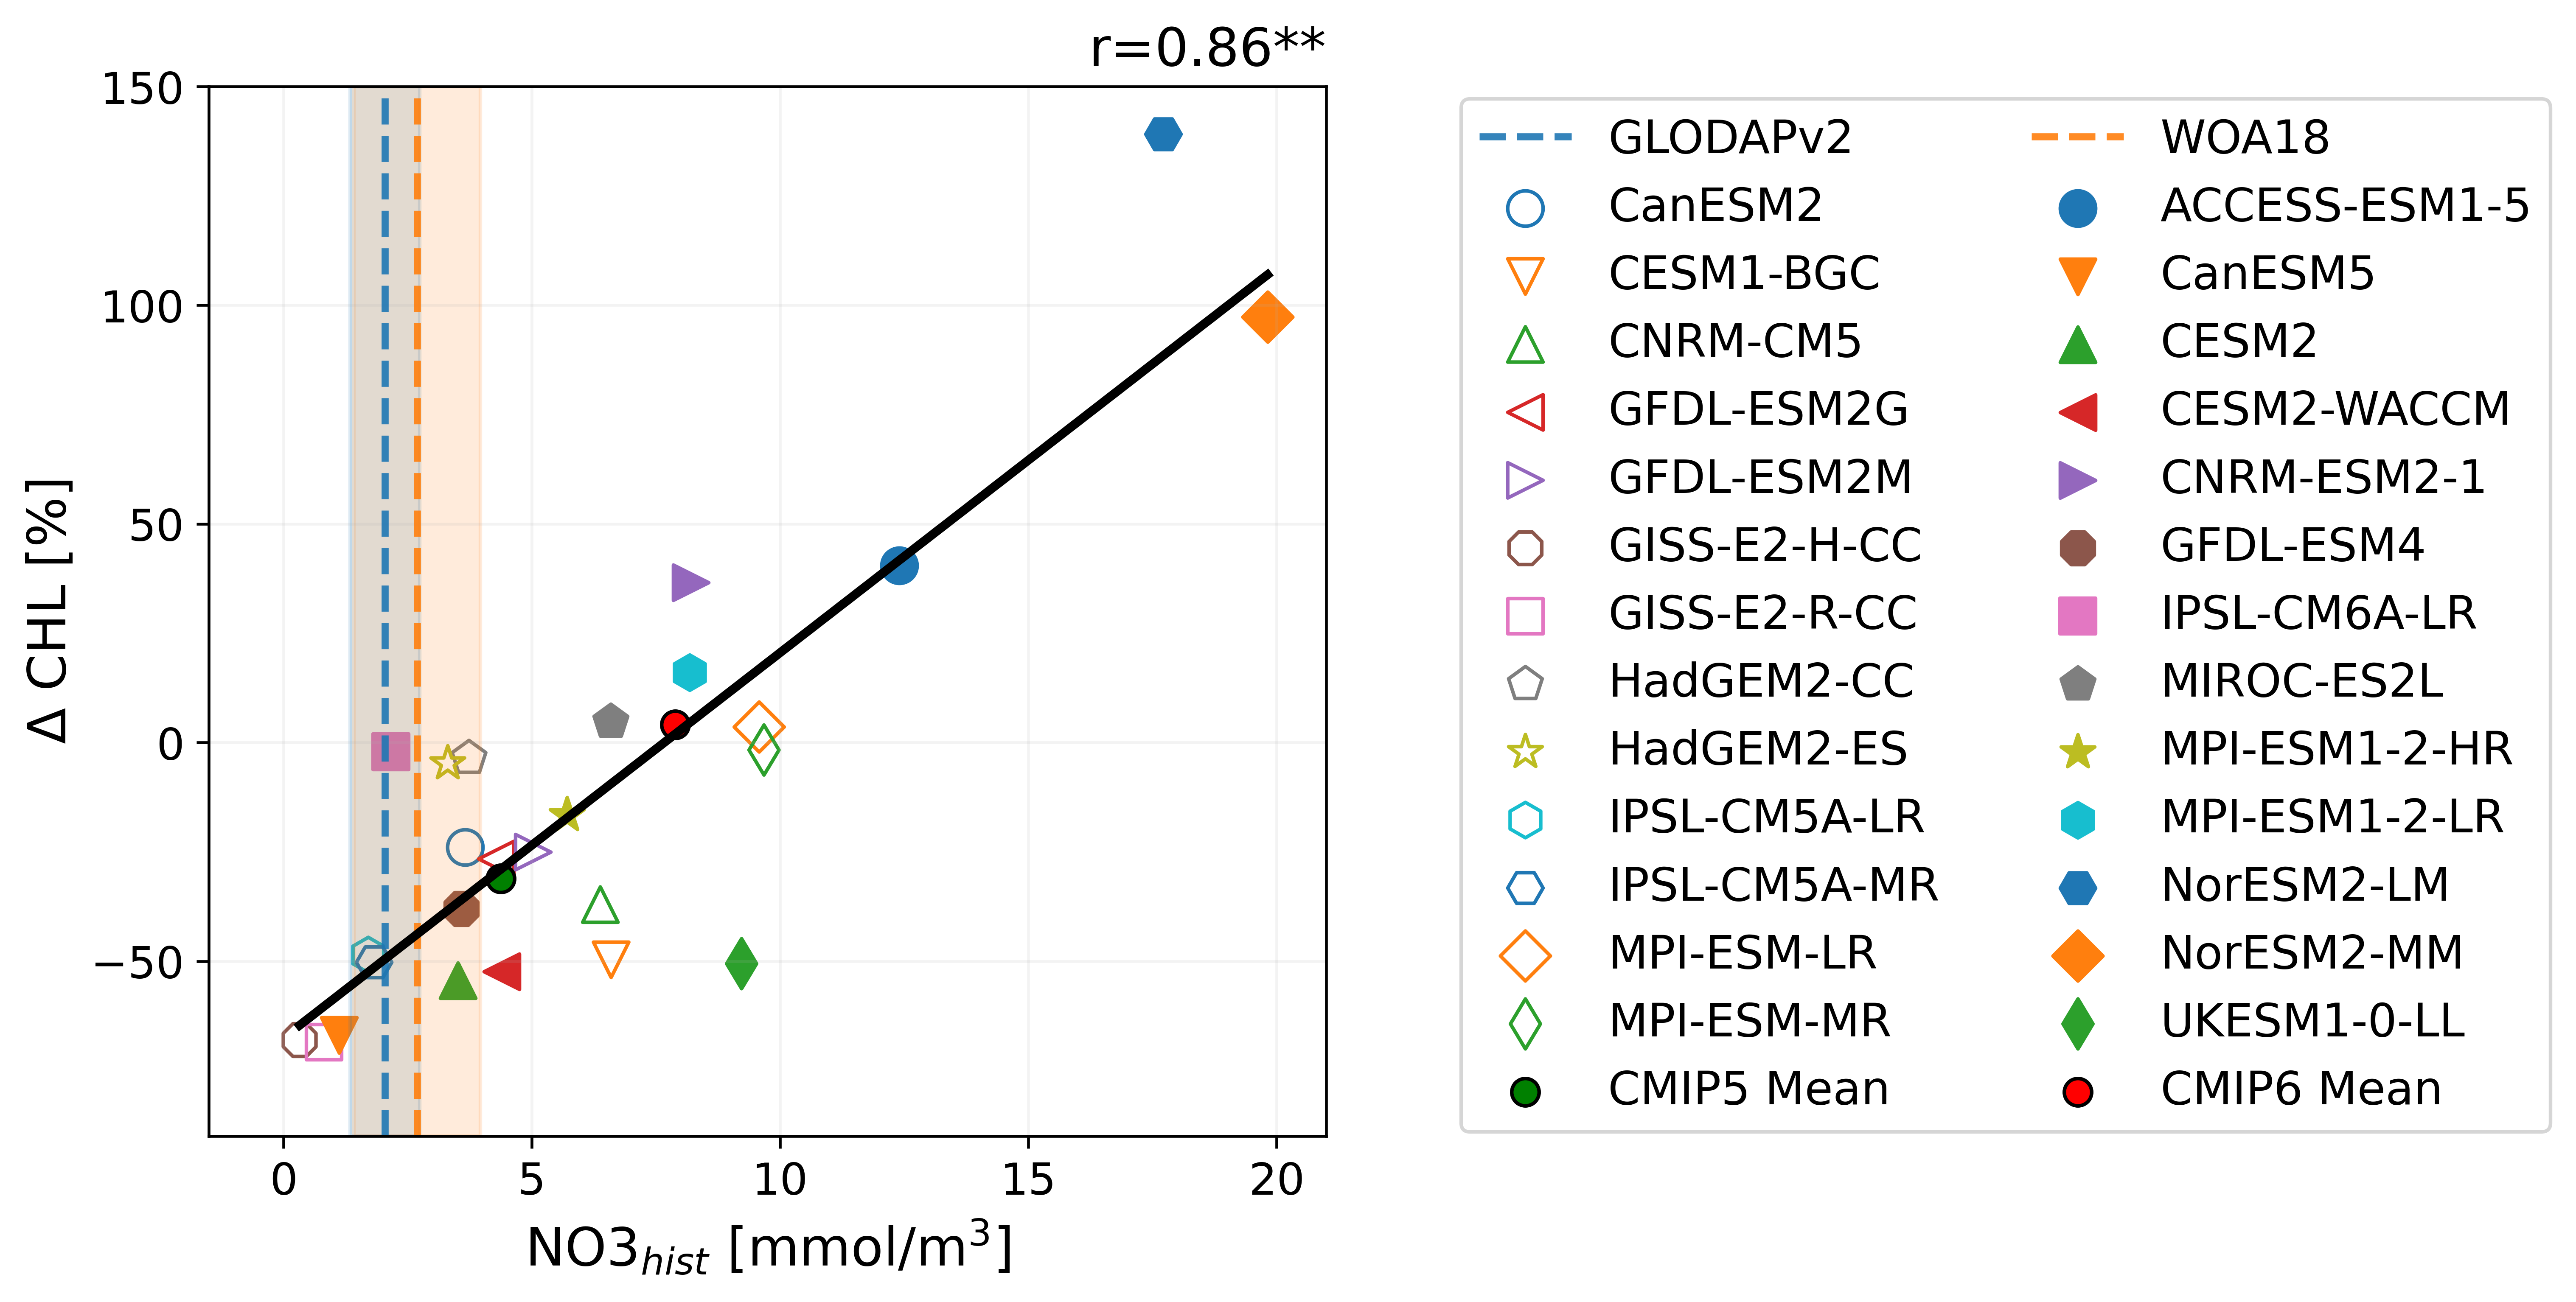

In [128]:
##########################################################################################
### Combine CMIP5 and CMIP6 Data to One array
##########################################################################################

tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL

tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3#.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )
tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL#.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )

tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

tmp_x = tmp_x[~np.isnan(tmp_y)]
tmp_y = tmp_y[~np.isnan(tmp_y)]

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


##########################################################################################
### Calculate NO3 PDF for WOA in the Arctic Ocean
##########################################################################################
mu_WOA_NO3        = NO3_WOA_mean.values
sigma_WOA_NO3     = NO3_WOA_std.values
PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


##########################################################################################
### Calculate NO3 PDF for GLODAP in the Arctic Ocean
##########################################################################################
mu_GLODAP_NO3     = NO3_GLODAP_mean.values
sigma_GLODAP_NO3  = NO3_GLODAP_std.values
PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


##########################################################################################
### Calculate Constrained CHL PDF with WOA, GLODAP Observation
##########################################################################################
PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


##########################################################################################
### Calculate CMIP meand and STD
##########################################################################################
tmp_mean = tmp_y.mean("model_name").values
tmp_std  = tmp_y.std("model_name").values

P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

print("CMIP56 : {:4.2f} ({:4.2f})".format(tmp_mean,tmp_std))
print("WOA Constrained : {:4.2f} ({:4.2f})".format(mean_WOA,sigma_WOA))
print("GLODAP Constrained : {:4.2f} ({:4.2f})".format(mean_GLODAP,sigma_GLODAP))

fig, axes = plt.subplots(1,1,figsize=(10,5),constrained_layout=True)

##########################################################################################
### Scatter Plot for NO3_Hist and PP Difference
##########################################################################################
axes.axvline(mu_GLODAP_NO3,
                linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                  tmp_x_CMIP5.model_name.values,'none',False,axes)
axes.scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
axes.axvline(mu_WOA_NO3,
                linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA18')

plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                  tmp_x_CMIP6.model_name.values,'filled',False,axes)

axes.scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')


##########################################################################################
### Linear-Regression for NO3_Hist and PP Difference
##########################################################################################
xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                          tmp_y.values.reshape(-1,1))
tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

axes.plot(xp,yp.T,'k-',linewidth=2.5)


##########################################################################################
### Mean NO3 and its Uncertainty in WOA and GLODAP
##########################################################################################
axes.axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                color='tab:blue',alpha=0.15)
axes.axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                color='tab:orange',alpha=0.15)




##########################################################################################
### Settings for Plots
##########################################################################################
axes.set_title("r={:4.2f}".format(tmp_corr)+"**",loc='right',fontsize=15)

axes.grid(alpha=0.15)
axes.set_xlim([-1.5,21]) 
axes.set_ylim([-90,150])
# axes.set_xlim([-1.5,14]) 
# axes.set_ylim([-60,40])

axes.set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
axes.set_ylabel("$\Delta$ CHL [%]",fontsize=15)

axes.tick_params(axis='both', which='major', labelsize=12.5)
axes.legend(fontsize=13, ncol=2,labelspacing=0.5,bbox_to_anchor=(1.1,1.01))


##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PDF_CMIP56_SSP585_CHL_NO3_LAT"+str(latS)+str(latN)+".pdf"
# file_name = "Scat_PDF_CMIP56_SSP585_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"
# file_name = "Scat_PDF_CMIP56_SSP245_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"
# file_name = "Scat_PDF_CMIP56_SSP126_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"

plt.savefig(dir_name+file_name)

### Out-of-sample-test

In [118]:
model_CMIP56 = tmp_x.model_name

In [131]:
mean_total = np.empty([26,3,3])  ; mean_total[:,:,:] = np.NaN
std_total  = np.empty([26,3,3])  ; std_total[:,:,:]  = np.NaN

scenario_list = [126,245,585]
for ind_scen in range(3):
    for ind_mod in range(len(model_CMIP56)):
        print(model_CMIP56[ind_mod].values)
        ##########################################################################################
        ### Combine CMIP5 and CMIP6 Data to One array
        ##########################################################################################

        tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
        tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3

        scenario = scenario_list[ind_scen]
        if (scenario == 126):
            tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_126_CHL
            tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_126_CHL

        if (scenario == 245):
            tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_245_CHL
            tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_245_CHL

        if (scenario == 585):
            tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL
            tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL


        tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name').where(model_CMIP56!=model_CMIP56[ind_mod])
        tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name').where(model_CMIP56!=model_CMIP56[ind_mod])

        tmp_x = tmp_x[~np.isnan(tmp_y)]
        tmp_y = tmp_y[~np.isnan(tmp_y)]

        x  = np.linspace(-5,20,251)
        y  = np.linspace(-140,140,3001)


        ##########################################################################################
        ### Calculate NO3 PDF for WOA in the Arctic Ocean
        ##########################################################################################
        mu_WOA_NO3        = NO3_WOA_mean.values
        sigma_WOA_NO3     = NO3_WOA_std.values
        PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


        ##########################################################################################
        ### Calculate NO3 PDF for GLODAP in the Arctic Ocean
        ##########################################################################################
        mu_GLODAP_NO3     = NO3_GLODAP_mean.values
        sigma_GLODAP_NO3  = NO3_GLODAP_std.values
        PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


        ##########################################################################################
        ### Calculate Constrained CHL PDF with WOA, GLODAP Observation
        ##########################################################################################
        PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
        PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


        ##########################################################################################
        ### Calculate CMIP meand and STD
        ##########################################################################################
        tmp_mean = tmp_y.mean("model_name").values
        tmp_std  = tmp_y.std("model_name").values

        P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

        mean_total[ind_mod,ind_scen,0] = tmp_mean    ;  std_total[ind_mod,ind_scen,0] = tmp_std
        mean_total[ind_mod,ind_scen,1] = mean_WOA    ;  std_total[ind_mod,ind_scen,1] = sigma_WOA
        mean_total[ind_mod,ind_scen,2] = mean_GLODAP ;  std_total[ind_mod,ind_scen,2] = sigma_GLODAP

CanESM2
CESM1-BGC
CNRM-CM5
GFDL-ESM2G
GFDL-ESM2M
GISS-E2-H-CC
GISS-E2-R-CC
HadGEM2-CC
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MPI-ESM-LR
MPI-ESM-MR
ACCESS-ESM1-5
CanESM5
CESM2
CESM2-WACCM
CNRM-ESM2-1
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-HR
MPI-ESM1-2-LR
NorESM2-LM
NorESM2-MM
UKESM1-0-LL
CanESM2
CESM1-BGC
CNRM-CM5
GFDL-ESM2G
GFDL-ESM2M
GISS-E2-H-CC
GISS-E2-R-CC
HadGEM2-CC
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MPI-ESM-LR
MPI-ESM-MR
ACCESS-ESM1-5
CanESM5
CESM2
CESM2-WACCM
CNRM-ESM2-1
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-HR
MPI-ESM1-2-LR
NorESM2-LM
NorESM2-MM
UKESM1-0-LL
CanESM2
CESM1-BGC
CNRM-CM5
GFDL-ESM2G
GFDL-ESM2M
GISS-E2-H-CC
GISS-E2-R-CC
HadGEM2-CC
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MPI-ESM-LR
MPI-ESM-MR
ACCESS-ESM1-5
CanESM5
CESM2
CESM2-WACCM
CNRM-ESM2-1
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-HR
MPI-ESM1-2-LR
NorESM2-LM
NorESM2-MM
UKESM1-0-LL


In [132]:
print(mean_total.mean(axis=0))
print(std_total.mean(axis=0))

[[ -5.93512876 -19.12974359 -21.3374359 ]
 [-11.48871229 -29.24205128 -32.66666667]
 [-13.4842012  -44.86461538 -50.92051282]]
[[22.72088506 18.8425641  18.60564103]
 [29.65276526 20.20666667 19.51025641]
 [48.66804021 29.14871795 27.60153846]]


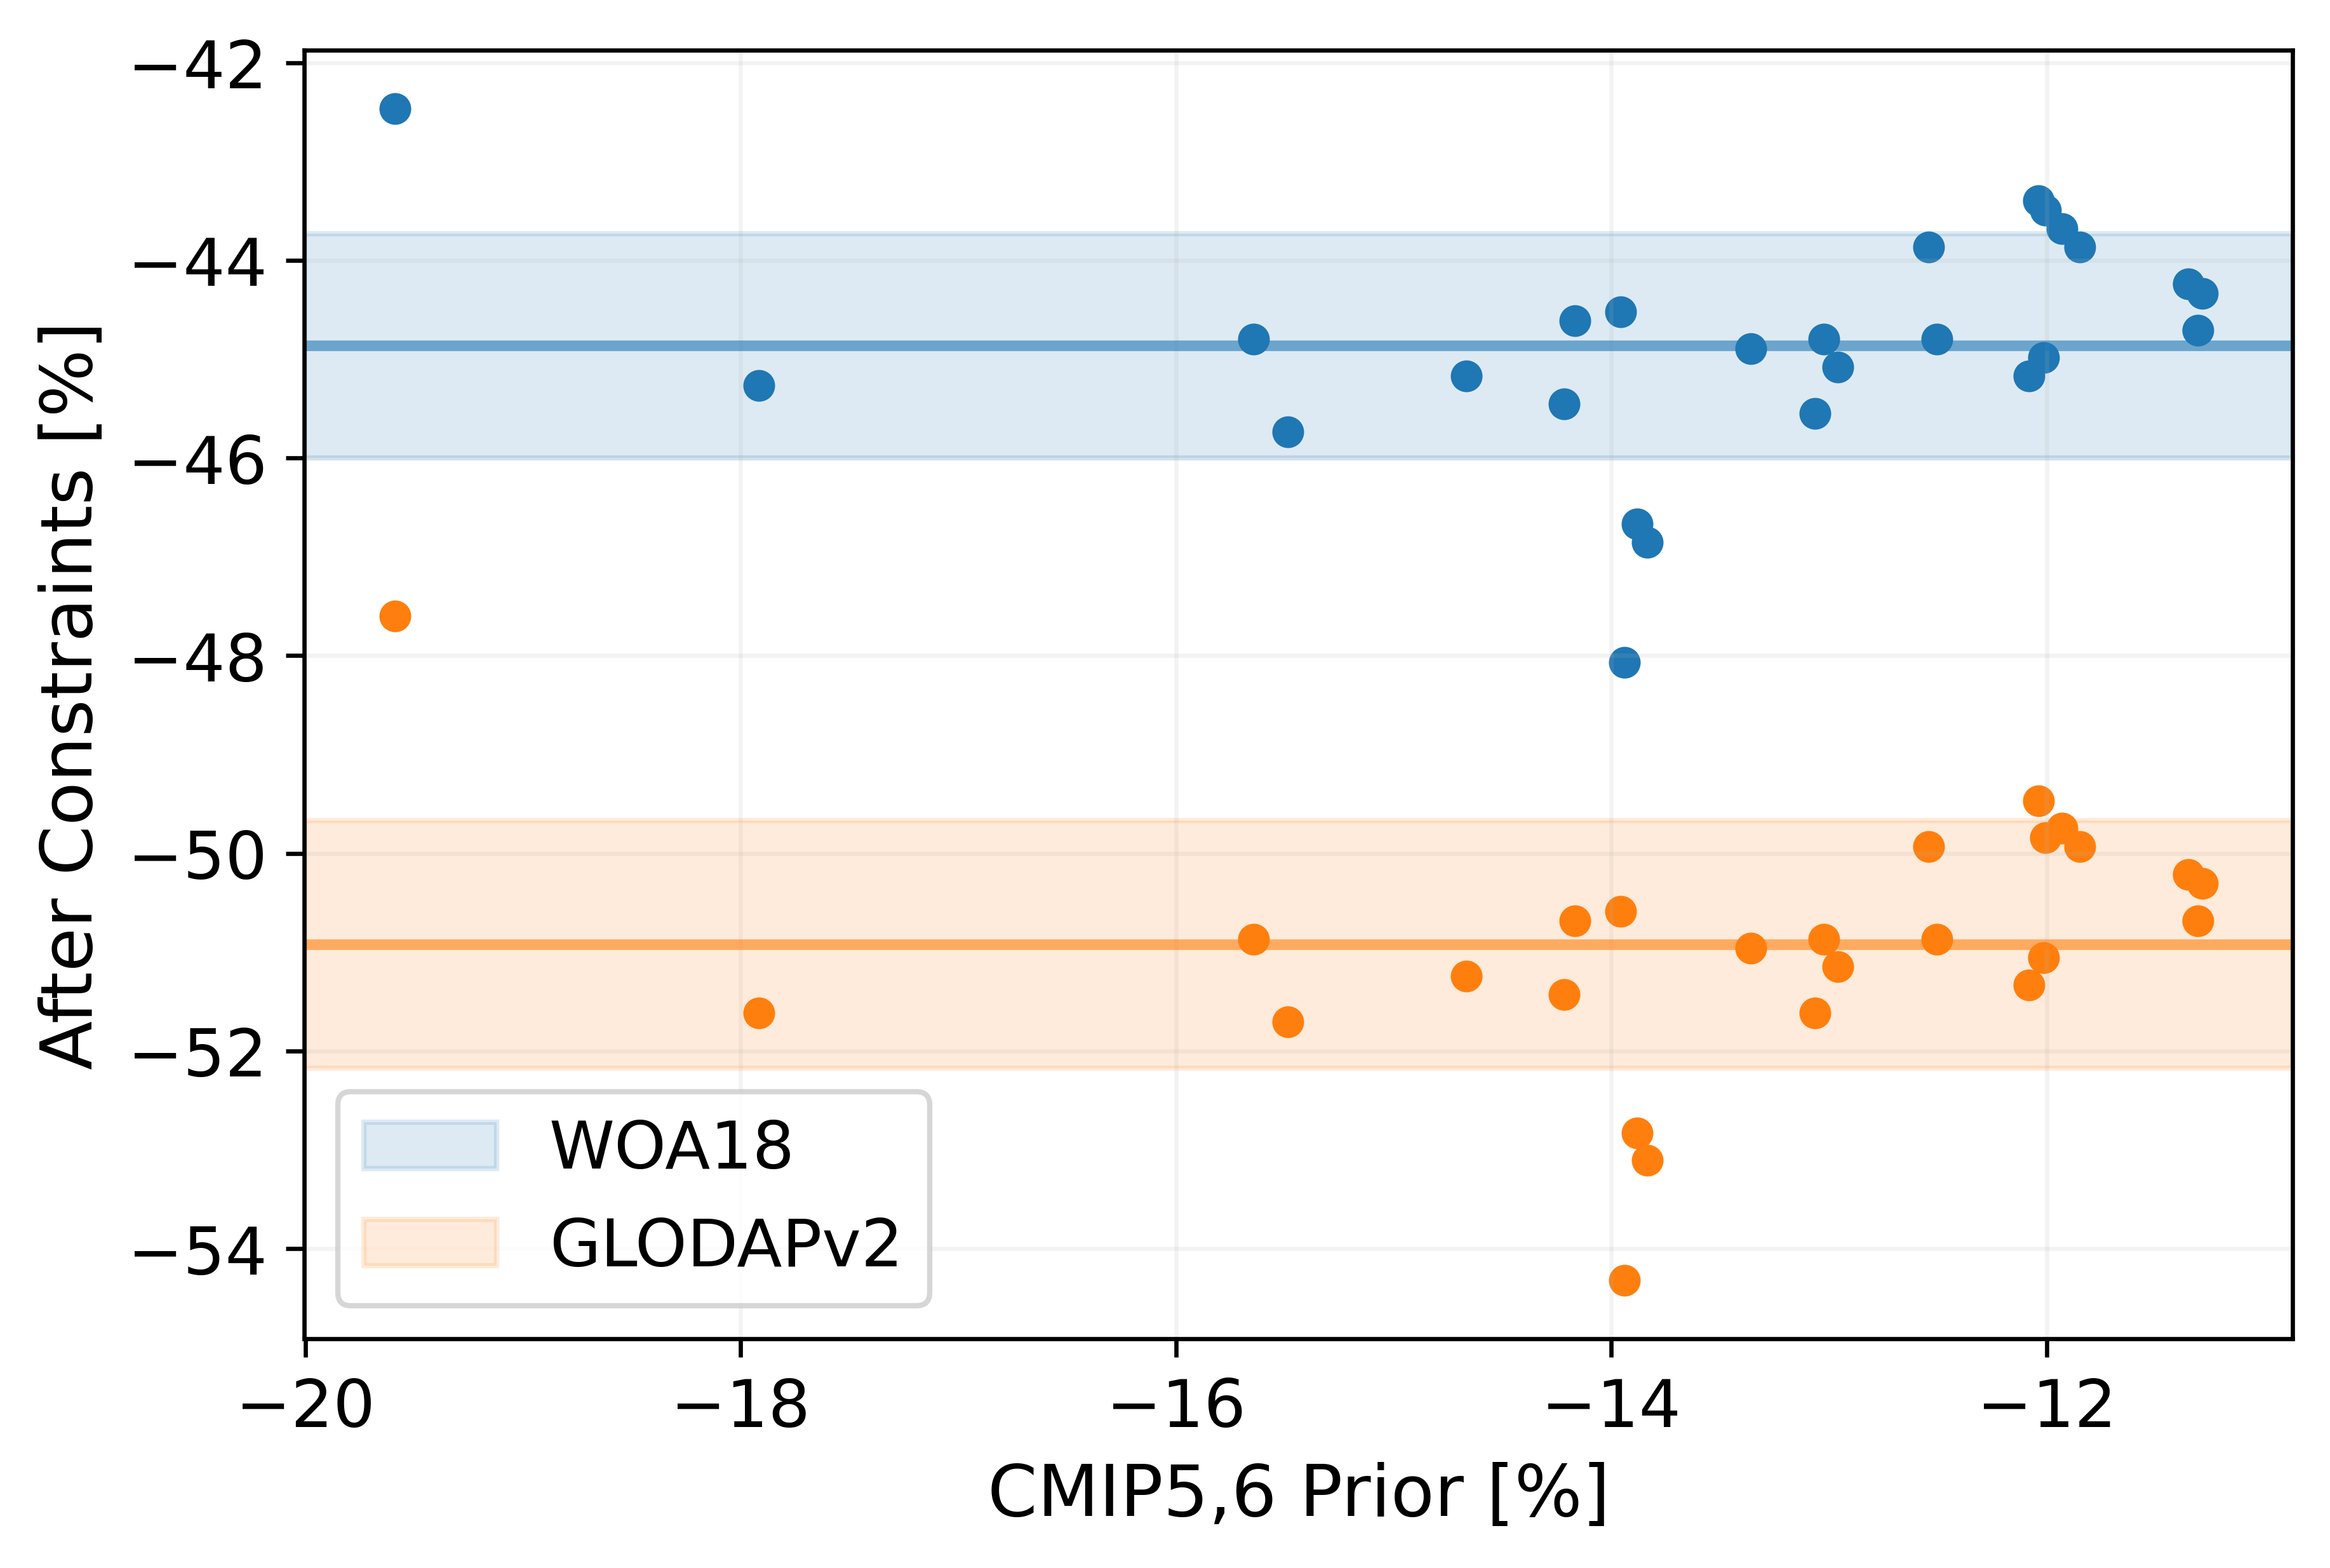

In [156]:
fig, axes = plt.subplots(1,1,figsize=(6,4),constrained_layout=True)


axes.scatter(mean_total[:,2,0],mean_total[:,2,1],s=25,color='tab:blue')
axes.scatter(mean_total[:,2,0],mean_total[:,2,2],s=25,color='tab:orange')

axes.axhline(mean_total[:,2,1].mean(),linewidth=2,alpha=0.6,color='tab:blue')
axes.axhspan(mean_total[:,2,1].mean()-mean_total[:,2,1].std(),
            mean_total[:,2,1].mean()+mean_total[:,2,1].std(),alpha=0.15,color='tab:blue',label='WOA18')


axes.axhline(mean_total[:,2,2].mean(),linewidth=2,alpha=0.6,color='tab:orange')
axes.axhspan(mean_total[:,2,2].mean()-mean_total[:,2,2].std(),
            mean_total[:,2,2].mean()+mean_total[:,2,2].std(),alpha=0.15,color='tab:orange',label='GLODAPv2')

axes.set_xlabel("CMIP5,6 Prior [%]",fontsize=13.5)
axes.set_ylabel("After Constraints [%]",fontsize=13.5)
axes.tick_params(axis='both', which='major', labelsize=12.5)

axes.legend(fontsize=12.5)
axes.grid(alpha=0.15)

##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PRIOR_CONSTRAIN_Excluding_Models.pdf"

plt.savefig(dir_name+file_name)

CMIP56 : -13.48 (48.76)
WOA Constrained : -44.80 (28.00)
GLODAP Constrained : -51.33 (26.13)


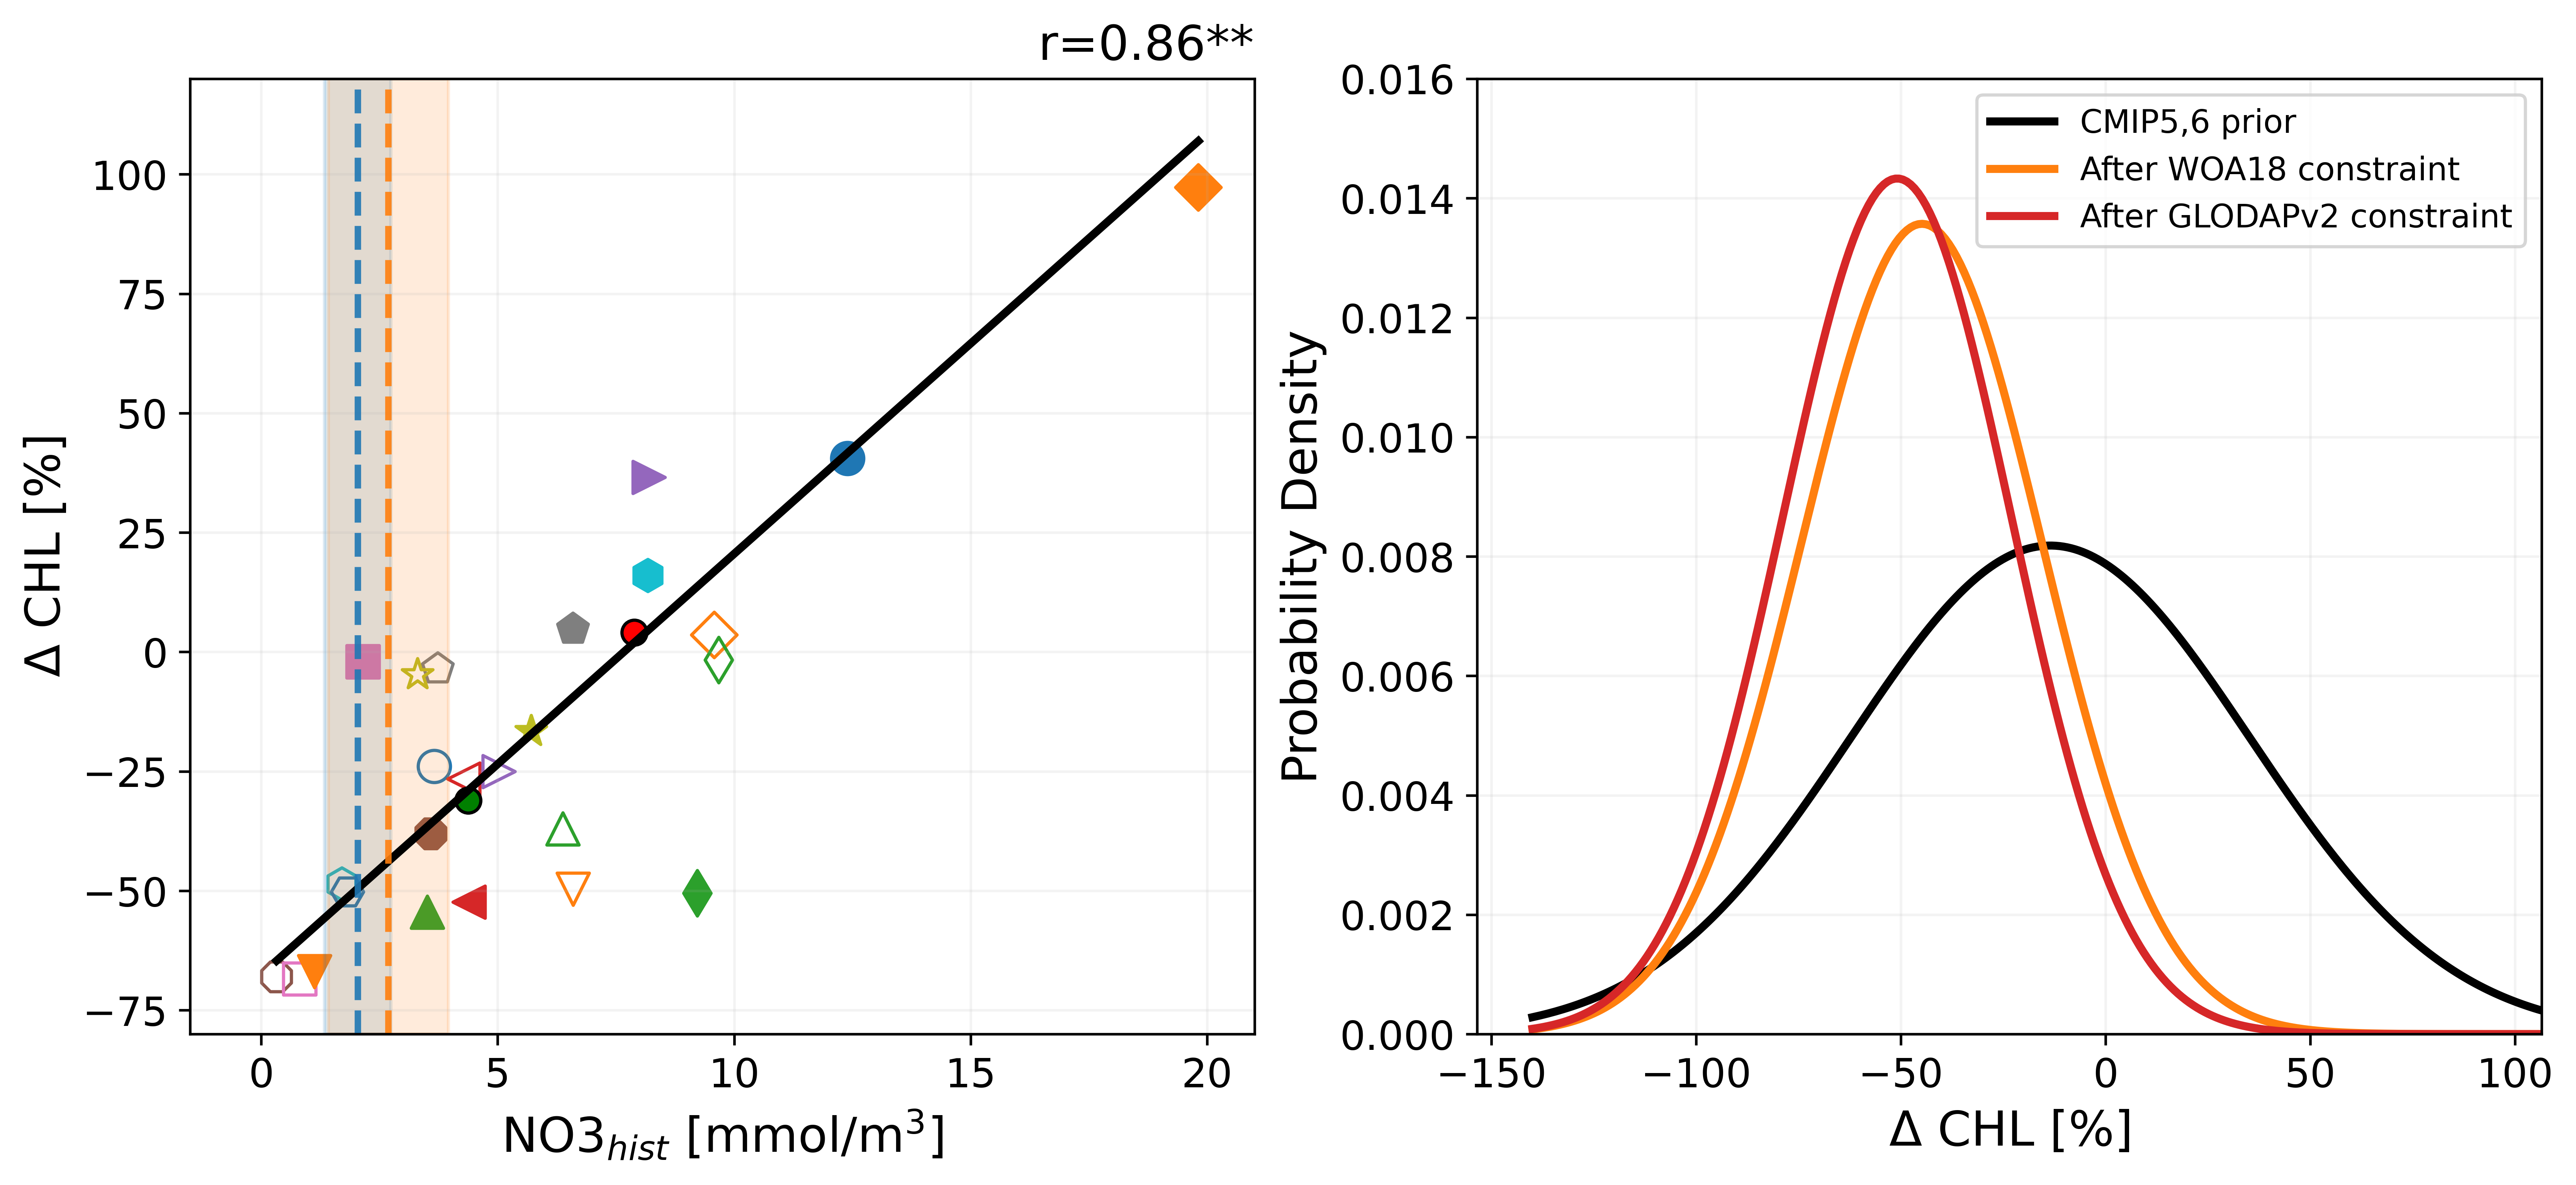

In [139]:
##########################################################################################
### Combine CMIP5 and CMIP6 Data to One array
##########################################################################################

tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL

tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3#.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )
tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL#.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )

tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

tmp_x = tmp_x[~np.isnan(tmp_y)]
tmp_y = tmp_y[~np.isnan(tmp_y)]

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


##########################################################################################
### Calculate NO3 PDF for WOA in the Arctic Ocean
##########################################################################################
mu_WOA_NO3        = NO3_WOA_mean.values
sigma_WOA_NO3     = NO3_WOA_std.values
PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


##########################################################################################
### Calculate NO3 PDF for GLODAP in the Arctic Ocean
##########################################################################################
mu_GLODAP_NO3     = NO3_GLODAP_mean.values
sigma_GLODAP_NO3  = NO3_GLODAP_std.values
PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


##########################################################################################
### Calculate Constrained CHL PDF with WOA, GLODAP Observation
##########################################################################################
PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


##########################################################################################
### Calculate CMIP meand and STD
##########################################################################################
tmp_mean = tmp_y.mean("model_name").values
tmp_std  = tmp_y.std("model_name").values

P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

print("CMIP56 : {:4.2f} ({:4.2f})".format(tmp_mean,tmp_std))
print("WOA Constrained : {:4.2f} ({:4.2f})".format(mean_WOA,sigma_WOA))
print("GLODAP Constrained : {:4.2f} ({:4.2f})".format(mean_GLODAP,sigma_GLODAP))

fig, axes = plt.subplots(1,2,figsize=(11,5),constrained_layout=True)

##########################################################################################
### Scatter Plot for NO3_Hist and PP Difference
##########################################################################################
plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                  tmp_x_CMIP5.model_name.values,'none',False,axes[0])
plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                  tmp_x_CMIP6.model_name.values,'filled',False,axes[0])

axes[0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
axes[0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')


##########################################################################################
### Linear-Regression for NO3_Hist and PP Difference
##########################################################################################
xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                          tmp_y.values.reshape(-1,1))
tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

axes[0].plot(xp,yp.T,'k-',linewidth=2.5)


##########################################################################################
### Mean NO3 and its Uncertainty in WOA and GLODAP
##########################################################################################
axes[0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                color='tab:blue',alpha=0.15)
axes[0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                color='tab:orange',alpha=0.15)

axes[0].axvline(mu_GLODAP_NO3,
                linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
axes[0].axvline(mu_WOA_NO3,
                linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


##########################################################################################
### Constrained PDF of PP Projection in WOA and GLODAP
##########################################################################################
axes[1].plot(y,P,'k',linewidth=2.5,label="CMIP5,6 prior")
axes[1].plot(y,PDF_WOA,'tab:orange',linewidth=2.5,label="After WOA18 constraint")
axes[1].plot(y,PDF_GLODAP,'tab:red',linewidth=2.5,label="After GLODAPv2 constraint")


##########################################################################################
### Settings for Plots
##########################################################################################
axes[0].set_title("r={:4.2f}".format(tmp_corr)+"**",loc='right',fontsize=15)

axes[0].grid(alpha=0.15)
# axes[0].set_xlim([-1.5,21]) 
# axes[0].set_ylim([-90,150])
axes[0].set_xlim([-1.5,21]) 
axes[0].set_ylim([-80,120])

axes[1].set_xlim([tmp_mean-140,tmp_mean+120])
axes[1].grid(alpha=0.15)
axes[1].legend(fontsize=10)

axes[0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
axes[0].set_ylabel("$\Delta$ CHL [%]",fontsize=15)


axes[1].set_xlabel("$\Delta$ CHL [%]",fontsize=15)
axes[1].set_ylabel("Probability Density",fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)

axes[1].set_ylim([0.00,0.016ㄹ])
# axes[1].set_yticks([0,0.005,0.01,0.015])
# axes[1].set_yticklabels([0.00,0.005,0.010,0.015], fontsize=12.5)


##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PDF_CMIP56_SSP585_CHL_NO3_LAT"+str(latS)+str(latN)+".pdf"
# file_name = "Scat_PDF_CMIP56_SSP585_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"
# file_name = "Scat_PDF_CMIP56_SSP245_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"
# file_name = "Scat_PDF_CMIP56_SSP126_CHL_NO3_LAT"+str(latS)+str(latN)+"_EXCEP_NORESM.pdf"


plt.savefig(dir_name+file_name)

In [39]:
def plot_scat_regline_no(x_array,y_array,label_name,face_color,regline,axes):    
    ma_x_array = np.ma.masked_invalid(x_array)
    ma_y_array = np.ma.masked_invalid(y_array)
    msk_x_y    = (~ma_x_array.mask & ~ma_y_array.mask)
    
    xp, yp = calc_lin_regline(x_array[msk_x_y].values.reshape(-1,1),
                              y_array[msk_x_y].values.reshape(-1,1) ) 
    
    for it in range(len(label_name)):        
        axes.scatter(x_array[it],y_array[it],s=125,facecolors='tab:blue',
                    edgecolors='blue',label=label_name[it],linewidth=2)

    if (regline): axes.plot(xp,yp.T,'-k',linewidth=2)

In [ ]:
fig, axes = plt.subplots(5,5,figsize=(25,25),constrained_layout=True)

for ind_comb in range(25):
    
    ind_x = ind_comb // 5
    ind_y = ind_comb % 5
    
    N_mod   = 16
    ind_mod = np.random.randint(0,24,size=(N_mod))

    tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
    tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL

    tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )
    tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL.where((model_CMIP6!="NorESM2-LM") & (model_CMIP6!="NorESM2-MM") )

    tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
    tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

    tmp_x = tmp_x[~np.isnan(tmp_y)][ind_mod]
    tmp_y = tmp_y[~np.isnan(tmp_y)][ind_mod]

    N_GLODAP2 = NO3_GLODAP_mean.values
    N_WOA13   = NO3_WOA_mean.values
    y_CHL  = np.linspace(-140,140,1001)


    tmp_mean = tmp_y.mean("model_name").values
    tmp_std  = tmp_y.std("model_name").values

    plot_scat_regline_no(tmp_x,tmp_y,
                        tmp_x.model_name.values,'filled',False,axes[ind_x][ind_y])

    print("")
    xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                              tmp_y.values.reshape(-1,1))
    tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)
    print("Corr : {:4.2f} ({:4.2e})".format(tmp_corr,tmp_pval))

    axes[ind_x][ind_y].plot(xp,yp.T,'k-',linewidth=2.5)

    axes[ind_x][ind_y].plot(N_GLODAP2*np.ones(50),1.3*np.linspace(-80,50),
                '--',color='tab:blue',linewidth=2.5,alpha=0.3,label='GLODAPv2')
    axes[ind_x][ind_y].plot(N_WOA13*np.ones(50),1.3*np.linspace(-80,50),
                '--',color='tab:orange',linewidth=2.5,alpha=0.3,label='WOA13')

    if     (tmp_pval <= 0.05): sig_type = "**"
    elif   (tmp_pval <= 0.1):  sig_type = "*"
    else:                      sig_type = ""
    axes[ind_x][ind_y].set_title("r={:4.2f}".format(tmp_corr)+str(sig_type),loc='right',fontsize=17.5)

    axes[ind_x][ind_y].grid(alpha=0.15)
    axes[ind_x][ind_y].set_xlim([-0.5,14])
    axes[ind_x][ind_y].set_ylim([-80,50])  ## SSP5-85 [CHL]

    axes[ind_x][ind_y].set_ylabel("$\Delta$ CHL [%]",fontsize=17.5)
    axes[ind_x][ind_y].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=17.5)
    axes[ind_x][ind_y].tick_params(axis='both', which='major', labelsize=15)


plt.savefig("./RESULT/Scat_PDF_CMIP56_SSP585_SAMPLING_"+str(N_mod)+"_CHL_NO3_LAT"+str(latS)+str(latN)+".pdf")

In [100]:
CDF_CMIP  = np.empty(len(P))
CDF_WOA13 = np.empty(len(PDF_WOA13))
CDF_GLODAP2 = np.empty(len(PDF_GLODAP2))

CDF_WOA13[0] = 0.0
for it in range(1,len(PDF_WOA13)):
    dy = (y_CHL[1]-y_CHL[0])
    CDF_CMIP[it]    = CDF_CMIP[it-1]    + P[it] * dy
    CDF_WOA13[it]   = CDF_WOA13[it-1]   + PDF_WOA13[it] * dy
    CDF_GLODAP2[it] = CDF_GLODAP2[it-1] + PDF_GLODAP2[it] * dy    

NameError: name 'PDF_WOA13' is not defined

In [791]:
print(mu_GLODAP_NO3,mu_WOA_NO3)

2.0421044064144667 2.689257091127768


In [47]:
model_name = CMIP6_mean_hist_NO3.model_name 
(1e+3*CMIP6_mean_hist_NO3.where((model_name=="ACCESS-ESM1-5") | 
                               (model_name=="CNRM-ESM2-1")   | 
                               (model_name=="MPI-ESM1-2-LR") |
                               (model_name=="NorESM2-MM")    | 
                               (model_name=="NorESM2-LM")  )  ).mean() - mu_WOA_NO3

<xarray.DataArray 'mean_hist' ()>
array(9.35281818)
Coordinates:
    season   <U3 'JJA'

In [102]:
tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3

fig, axes = plt.subplots(3,2,figsize=(11,15),constrained_layout=True)

scenario_list = [126,245,585]
for ind_scen in range(3):
# for ind_scen in range(2,3):
    scenario = scenario_list[ind_scen]
    if (scenario == 126):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_126_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_126_CHL
        y_range     = [-60,40]
        scenario_name = "SSP1-2.6"
    if (scenario == 245):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_245_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_245_CHL
        y_range     = [-70,60]    
        scenario_name = "SSP2-4.5"    
    if (scenario == 585):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL
        y_range     = [-90,150]
        scenario_name = "SSP5-8.5"
    

    tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
    tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

    tmp_x = tmp_x[~np.isnan(tmp_y)]
    tmp_y = tmp_y[~np.isnan(tmp_y)]

    x  = np.linspace(-5,20,251)
    y  = np.linspace(-140,140,3001)


    ##########################################################################################
    ### Calculate NO3 PDF for WOA in the Arctic Ocean
    ##########################################################################################
    mu_WOA_NO3        = NO3_WOA_mean.values
    sigma_WOA_NO3     = NO3_WOA_err.values
    PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


    ##########################################################################################
    ### Calculate NO3 PDF for GLODAP in the Arctic Ocean
    ##########################################################################################
    mu_GLODAP_NO3     = NO3_GLODAP_mean.values
    sigma_GLODAP_NO3  = NO3_GLODAP_std.values
    PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


    ##########################################################################################
    ### Calculate Constrained CHL PDF with WOA, GLODAP Observation
    ##########################################################################################
    PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
    PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)

    
    ##########################################################################################
    ### Calculate CMIP meand and STD
    ##########################################################################################
    tmp_mean = tmp_y.mean("model_name").values
    tmp_std  = tmp_y.std("model_name").values

    P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

    print("CMIP5,6 Priori : {:4.2f} [mean], {:4.2f} [std]".format(tmp_mean,tmp_std))
    print("WOA18 Constrained : {:4.2f} [mean], {:4.2f} [std]".format(mean_WOA,sigma_WOA))
    print("GLODAPv2 Constrained : {:4.2f} [mean], {:4.2f} [std]".format(mean_GLODAP,sigma_GLODAP))


    ##########################################################################################
    ### Linear-Regression for NO3_Hist and CHL Difference
    ##########################################################################################
    plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                      tmp_x_CMIP5.model_name.values,'none',False,axes[ind_scen][0])
    plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                      tmp_x_CMIP6.model_name.values,'filled',False,axes[ind_scen][0])
    print("")
    
    xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                              tmp_y.values.reshape(-1,1))
    tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

    axes[ind_scen][0].plot(xp,yp.T,'k-',linewidth=2.5)

    ##########################################################################################
    ### Mean NO3 and its Uncertainty in WOA and GLODAP
    ##########################################################################################
    axes[ind_scen][0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                    color='tab:blue',alpha=0.15)
    axes[ind_scen][0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                    color='tab:orange',alpha=0.15)

    axes[ind_scen][0].axvline(mu_GLODAP_NO3,
                    linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
    axes[ind_scen][0].axvline(mu_WOA_NO3,
                    linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


    axes[ind_scen][0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                    facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
    axes[ind_scen][0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                    facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')
    
    ##########################################################################################
    ### Settings for Scatter Plots
    ##########################################################################################    
    if   (tmp_pval <= 0.05): sig_type = "**"
    elif (tmp_pval <= 0.10): sig_type = "*"
    else:                    sig_type=""
        
    axes[ind_scen][0].set_title("r={:4.2f}".format(tmp_corr)+sig_type,loc='right',fontsize=15)
    axes[ind_scen][0].set_title("     "+str(scenario_name),loc='left',fontsize=15)

    axes[ind_scen][0].grid(alpha=0.15)
    axes[ind_scen][0].set_xlim([-0.5,21])

    axes[ind_scen][0].set_ylim(y_range)  ## SSP5-85 [CHL]
    axes[ind_scen][0].set_ylabel("$\Delta$ CHL [%]",fontsize=15)
    axes[ind_scen][0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
    axes[ind_scen][0].tick_params(axis='both', which='major', labelsize=15)
    
    
    ##########################################################################################
    ### Calculate Cumulative Density Functions
    ##########################################################################################        
    CDF_CMIP   = np.zeros(len(P))
    CDF_WOA    = np.zeros(len(PDF_WOA))
    CDF_GLODAP = np.zeros(len(PDF_GLODAP))

    for it in range(1,len(PDF_WOA)):
        dy = (y[1]-y[0])
        CDF_CMIP[it]    = CDF_CMIP[it-1]    + P[it] * dy
        CDF_WOA[it]     = CDF_WOA[it-1]     + PDF_WOA[it] * dy
        CDF_GLODAP[it]  = CDF_GLODAP[it-1]  + PDF_GLODAP[it] * dy    

        
    ##########################################################################################
    ### Plot Cumulative Density Functions based on Gaussian Distribution
    ##########################################################################################        
    axes[ind_scen][1].fill_between(y,CDF_GLODAP,CDF_WOA,color='tab:red',alpha=0.2)
    axes[ind_scen][1].fill_between(y,CDF_WOA,CDF_CMIP,color='tab:orange',alpha=0.2)
    axes[ind_scen][1].fill_between(y,CDF_CMIP,0,color='tab:blue',alpha=0.2)

    axes[ind_scen][1].plot(y,CDF_CMIP,color='tab:blue',linewidth=3,label='CMIP5,6 Prior')
    axes[ind_scen][1].plot(y,CDF_WOA,color='tab:orange',linewidth=3,label='After WOA18 constraint')
    axes[ind_scen][1].plot(y,CDF_GLODAP,color='tab:red',linewidth=3,label='After GLODAPv2 constraint')

    
    ##########################################################################################
    ### Plot Cumulative Density Function based on Real CMIP Distribution
    ##########################################################################################        
    axes[ind_scen][1].hist(tmp_y, bins=np.linspace(-100,75),density=True, histtype='step', 
                           cumulative=1,hatch='//',alpha=0.5,color='tab:blue',linewidth=2)
    
    
    ##########################################################################################
    ### Plot Scatters on CHL = 0 Points
    ##########################################################################################        
    axes[ind_scen][1].scatter(0,CDF_CMIP[1500],color='tab:blue',s=100)
    axes[ind_scen][1].scatter(0,CDF_WOA[1500],color='tab:orange',s=100)
    axes[ind_scen][1].scatter(0,CDF_GLODAP[1500],color='tab:red',s=100)
    print("CMIP[{:4.2f}], WOA[{:4.2f}], GLODAP[{:4.2f}]".format(\
                                                100*CDF_CMIP[1500],100*CDF_WOA[1500],100*CDF_GLODAP[1500]))
    print("")
    
    ##########################################################################################
    ### Settings for CDF Plots
    ##########################################################################################        
    axes[ind_scen][1].legend(fontsize=10.5,loc='lower right')
    axes[ind_scen][1].plot(np.zeros(50),np.linspace(0,1),'k--',linewidth=1,alpha=0.3)

    axes[ind_scen][1].set_xlim([-100,75])
    axes[ind_scen][1].set_xlabel("$\Delta$CHL [%]",fontsize=15)
    axes[ind_scen][1].set_ylabel("Probability [%]",fontsize=15)
    axes[ind_scen][1].grid(alpha=0.15)
    
    axes[ind_scen][1].tick_params(axis='both', which='major', labelsize=15)

    
##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name = "./RESULT/"
file_name = "Scat_PDF_CMIP5_"+str(scenario_name)+"_CHL_NO3_LAT_"+str(latS)+str(latN)+".pdf"
# file_name = "Scat_PDF_CMIP6_"+str(scenario_name)+"_CHL_NO3_LAT_"+str(latS)+str(latN)+".pdf"
# file_name = "Scat_PDF_CMIP56_"+str(scenario_name)+"_CHL_NO3_LAT_"+str(latS)+str(latN)+".pdf"
plt.savefig(dir_name+file_name)

CMIP5,6 Priori : -5.94 [mean], 22.75 [std]
WOA18 Constrained : -19.23 [mean], 18.39 [std]
GLODAPv2 Constrained : -21.28 [mean], 18.57 [std]

CMIP[60.37], WOA[85.00], GLODAP[87.28]

CMIP5,6 Priori : -11.49 [mean], 29.69 [std]
WOA18 Constrained : -29.31 [mean], 19.23 [std]
GLODAPv2 Constrained : -32.67 [mean], 19.51 [std]

CMIP[65.12], WOA[93.49], GLODAP[95.20]

CMIP5,6 Priori : -13.48 [mean], 48.76 [std]
WOA18 Constrained : -44.99 [mean], 27.07 [std]
GLODAPv2 Constrained : -50.87 [mean], 27.63 [std]

CMIP[60.46], WOA[95.04], GLODAP[96.60]



0.605, 0.936, 0.970


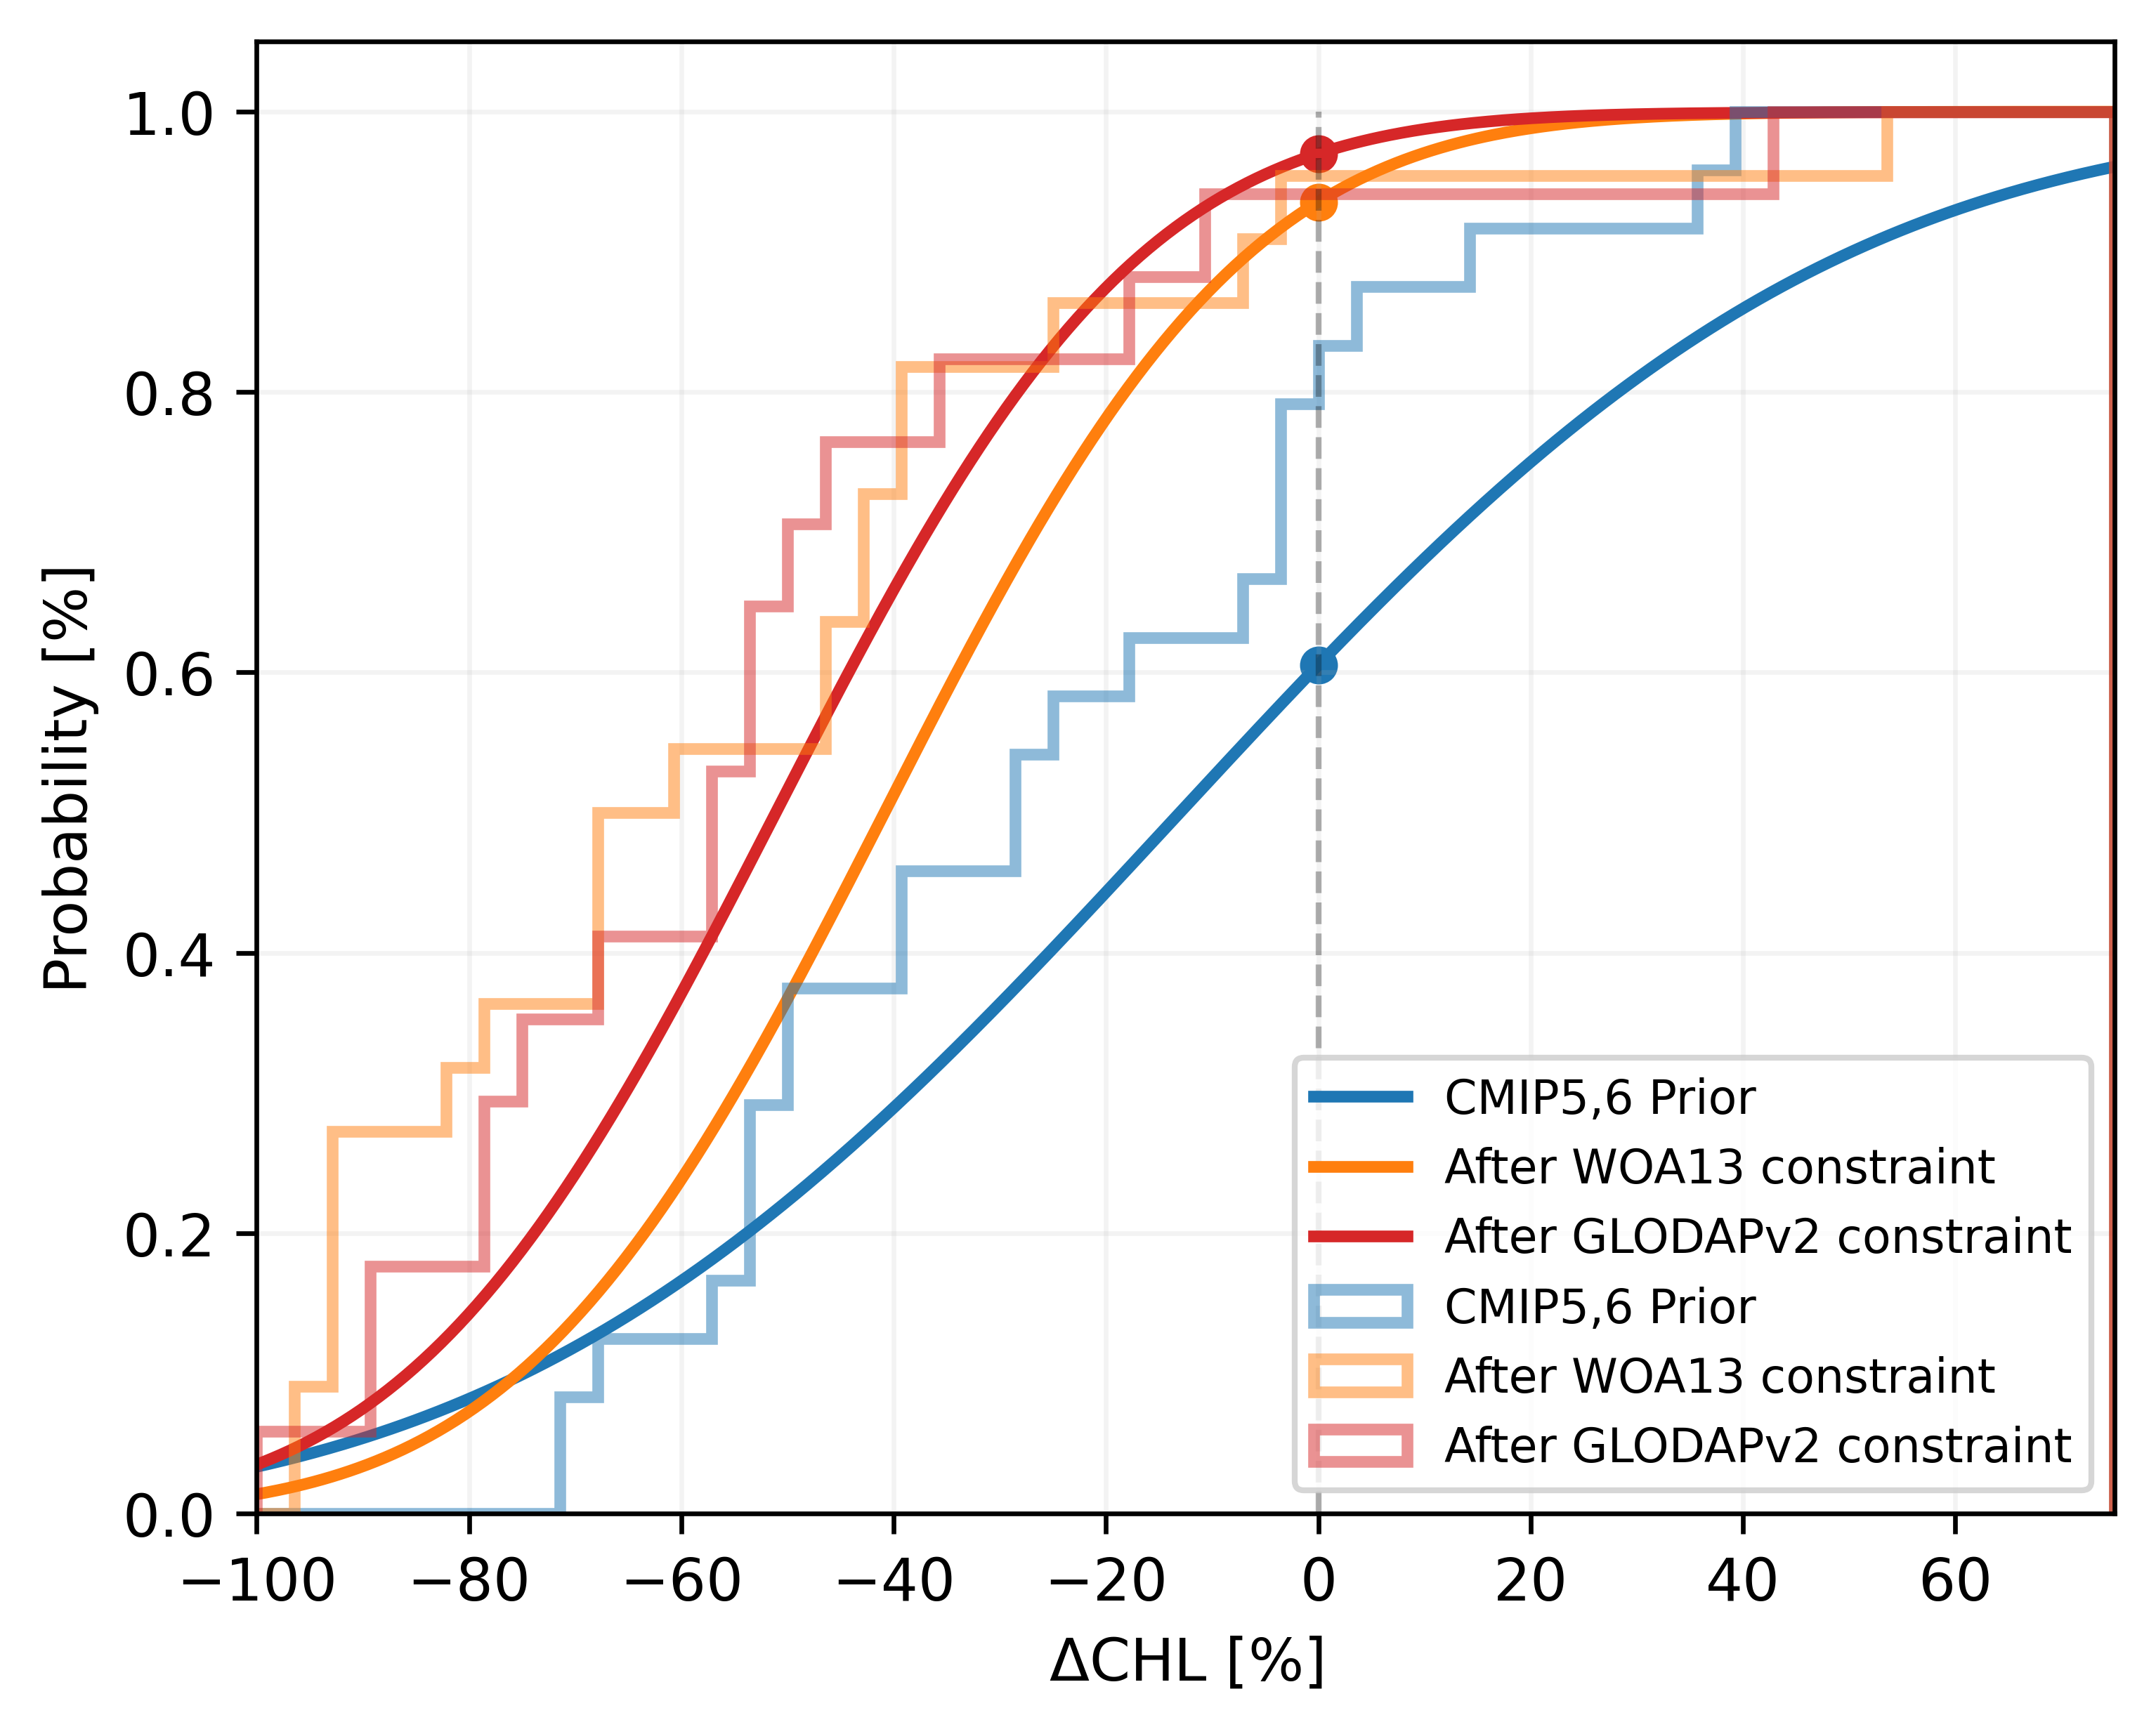

In [35]:
fig, axes = plt.subplots(1,1,figsize=(5,4),constrained_layout=True)

# axes.fill_between(y_CHL,CDF_GLODAP2,CDF_WOA13,color='tab:red',alpha=0.2)
# axes.fill_between(y_CHL,CDF_WOA13,CDF_CMIP,color='tab:orange',alpha=0.2)
# axes.fill_between(y_CHL,CDF_CMIP,0,color='tab:blue',alpha=0.2)

axes.plot(y_CHL,CDF_CMIP,color='tab:blue',linewidth=2,label='CMIP5,6 Prior')
axes.plot(y_CHL,CDF_WOA13,color='tab:orange',linewidth=2,label='After WOA13 constraint')
axes.plot(y_CHL,CDF_GLODAP2,color='tab:red',linewidth=2,label='After GLODAPv2 constraint')

axes.hist(tmp_y, bins=np.linspace(-100,75),density=True, histtype='step', 
          cumulative=1,hatch='',alpha=0.5,color='tab:blue',linewidth=2,label='CMIP5,6 Prior')
axes.hist(tmp_y+mean_1, bins=np.linspace(-100,75),density=True, histtype='step', 
          cumulative=1,hatch='',alpha=0.5,color='tab:orange',linewidth=2,label='After WOA13 constraint')
axes.hist(tmp_y+mean_2, bins=np.linspace(-100,75),density=True, histtype='step', 
          cumulative=1,hatch='',alpha=0.5,color='tab:red',linewidth=2,label='After GLODAPv2 constraint')

axes.scatter(0,CDF_CMIP[500],color='tab:blue',s=30)
axes.scatter(0,CDF_WOA13[500],color='tab:orange',s=30)
axes.scatter(0,CDF_GLODAP2[500],color='tab:red',s=30)
print("{:4.3f}, {:4.3f}, {:4.3f}".format(CDF_CMIP[500],CDF_WOA13[500],CDF_GLODAP2[500]))
axes.legend(fontsize=8)
axes.plot(np.zeros(50),np.linspace(0,1),'k--',linewidth=1,alpha=0.3)

axes.set_xlim([-100,75])
axes.set_xlabel("$\Delta$CHL [%]")
axes.set_ylabel("Probability [%]")
axes.grid(alpha=0.15)

plt.savefig("./RESULT/CDF_CMIP56_SSP585_CHL_"+str(latS)+str(latN)+".pdf")

[Text(1.0, 0, 'CanESM2'),
 Text(2.0, 0, 'CESM1-BGC'),
 Text(3.0, 0, 'CNRM-CM5'),
 Text(4.0, 0, 'GFDL-ESM2G'),
 Text(5.0, 0, 'GFDL-ESM2M'),
 Text(6.0, 0, 'GISS-E2-H-CC'),
 Text(7.0, 0, 'GISS-E2-R-CC'),
 Text(8.0, 0, 'HadGEM2-CC'),
 Text(9.0, 0, 'HadGEM2-ES'),
 Text(10.0, 0, 'IPSL-CM5A-LR'),
 Text(11.0, 0, 'IPSL-CM5A-MR'),
 Text(12.0, 0, 'MPI-ESM-LR'),
 Text(13.0, 0, 'MPI-ESM-MR'),
 Text(14.0, 0, 'ACCESS-ESM1-5'),
 Text(15.0, 0, 'CanESM5'),
 Text(16.0, 0, 'CESM2'),
 Text(17.0, 0, 'CESM2-WACCM'),
 Text(18.0, 0, 'CNRM-ESM2-1'),
 Text(19.0, 0, 'GFDL-ESM4'),
 Text(20.0, 0, 'IPSL-CM6A-LR'),
 Text(21.0, 0, 'MIROC-ES2L'),
 Text(22.0, 0, 'MPI-ESM1-2-HR'),
 Text(23.0, 0, 'MPI-ESM1-2-LR'),
 Text(24.0, 0, 'NorESM2-LM'),
 Text(25.0, 0, 'NorESM2-MM'),
 Text(26.0, 0, 'UKESM1-0-LL')]

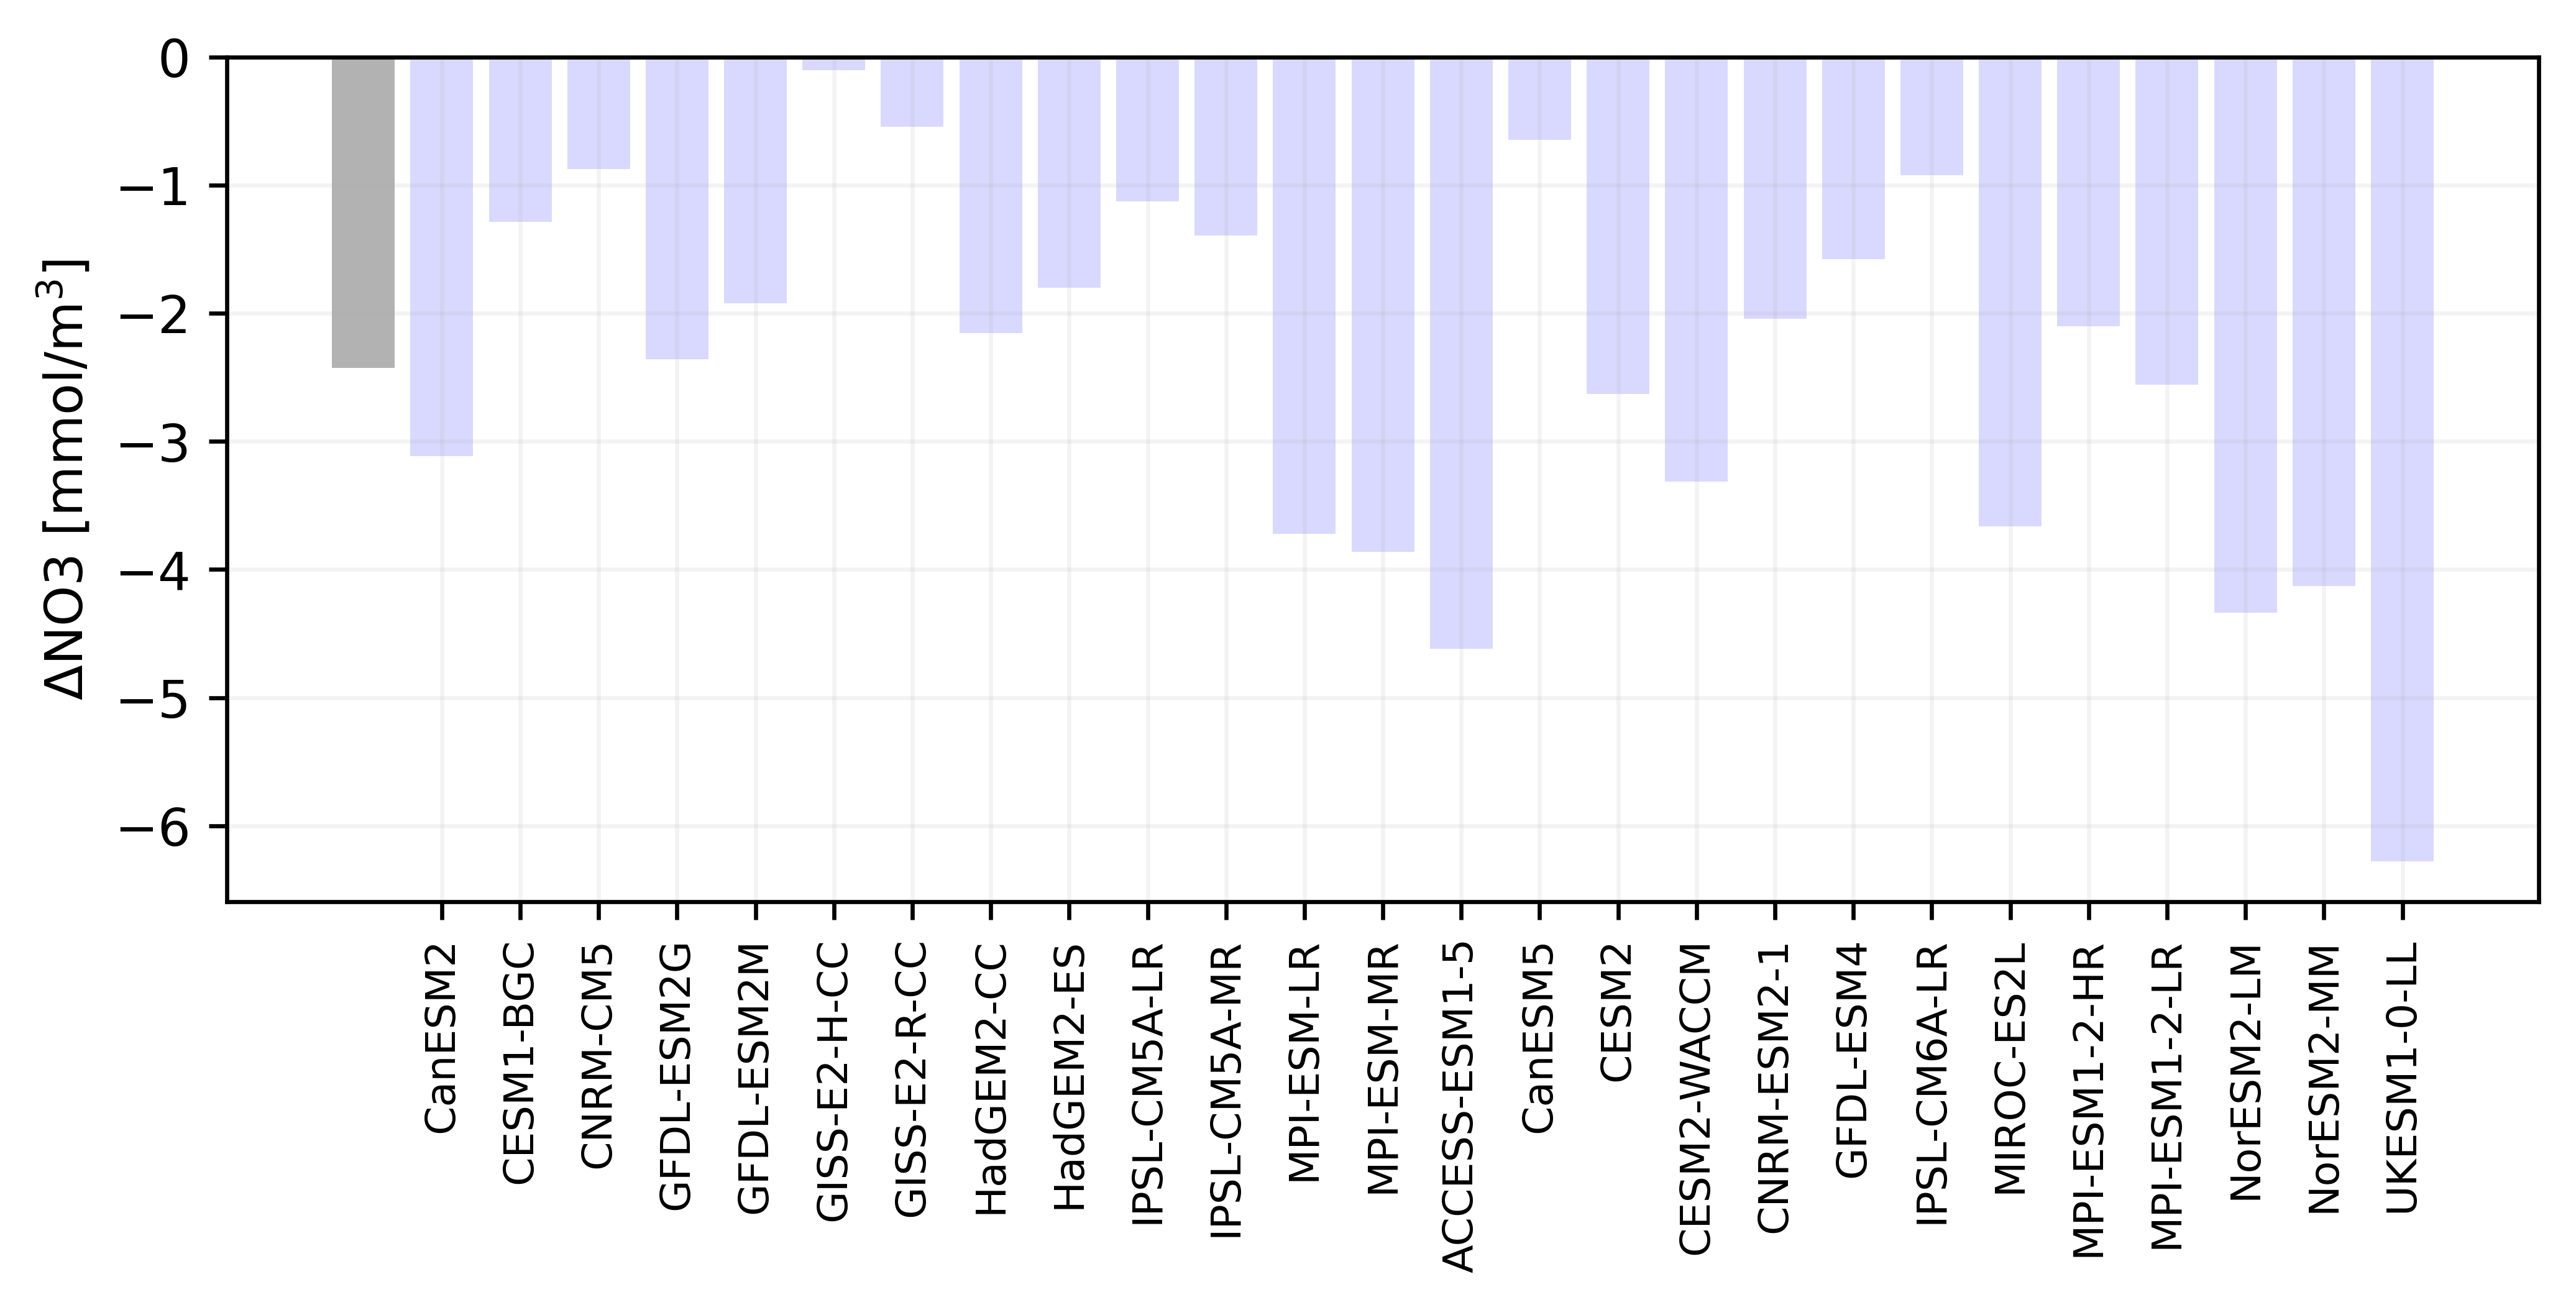

In [34]:
fig, axes = plt.subplots(1,1,figsize=(8,3))
tmp_x = np.linspace(1,26,26)
tmp = (tmp_mean_NO3*tmp_diff_NO3/100)

axes.bar(0,tmp.mean("model_name"),color='grey',alpha=0.6)
axes.bar(np.linspace(1,26,26),tmp,color='b',alpha=0.15)
axes.grid(alpha=0.15)
axes.set_ylabel("$\Delta$NO3 [mmol/m$^3$]")
axes.set_xticks(tmp_x)
axes.set_xticklabels(tmp.model_name.values, 
                     rotation='vertical', fontsize=8)

[Text(1.0, 0, 'CanESM2'),
 Text(2.0, 0, 'CESM1-BGC'),
 Text(3.0, 0, 'CNRM-CM5'),
 Text(4.0, 0, 'GFDL-ESM2G'),
 Text(5.0, 0, 'GFDL-ESM2M'),
 Text(6.0, 0, 'GISS-E2-H-CC'),
 Text(7.0, 0, 'GISS-E2-R-CC'),
 Text(8.0, 0, 'HadGEM2-CC'),
 Text(9.0, 0, 'HadGEM2-ES'),
 Text(10.0, 0, 'IPSL-CM5A-LR'),
 Text(11.0, 0, 'IPSL-CM5A-MR'),
 Text(12.0, 0, 'MPI-ESM-LR'),
 Text(13.0, 0, 'MPI-ESM-MR'),
 Text(14.0, 0, 'ACCESS-ESM1-5'),
 Text(15.0, 0, 'CanESM5'),
 Text(16.0, 0, 'CESM2'),
 Text(17.0, 0, 'CESM2-WACCM'),
 Text(18.0, 0, 'CNRM-ESM2-1'),
 Text(19.0, 0, 'GFDL-ESM4'),
 Text(20.0, 0, 'IPSL-CM6A-LR'),
 Text(21.0, 0, 'MIROC-ES2L'),
 Text(22.0, 0, 'MPI-ESM1-2-HR'),
 Text(23.0, 0, 'MPI-ESM1-2-LR'),
 Text(24.0, 0, 'NorESM2-LM'),
 Text(25.0, 0, 'NorESM2-MM'),
 Text(26.0, 0, 'UKESM1-0-LL')]

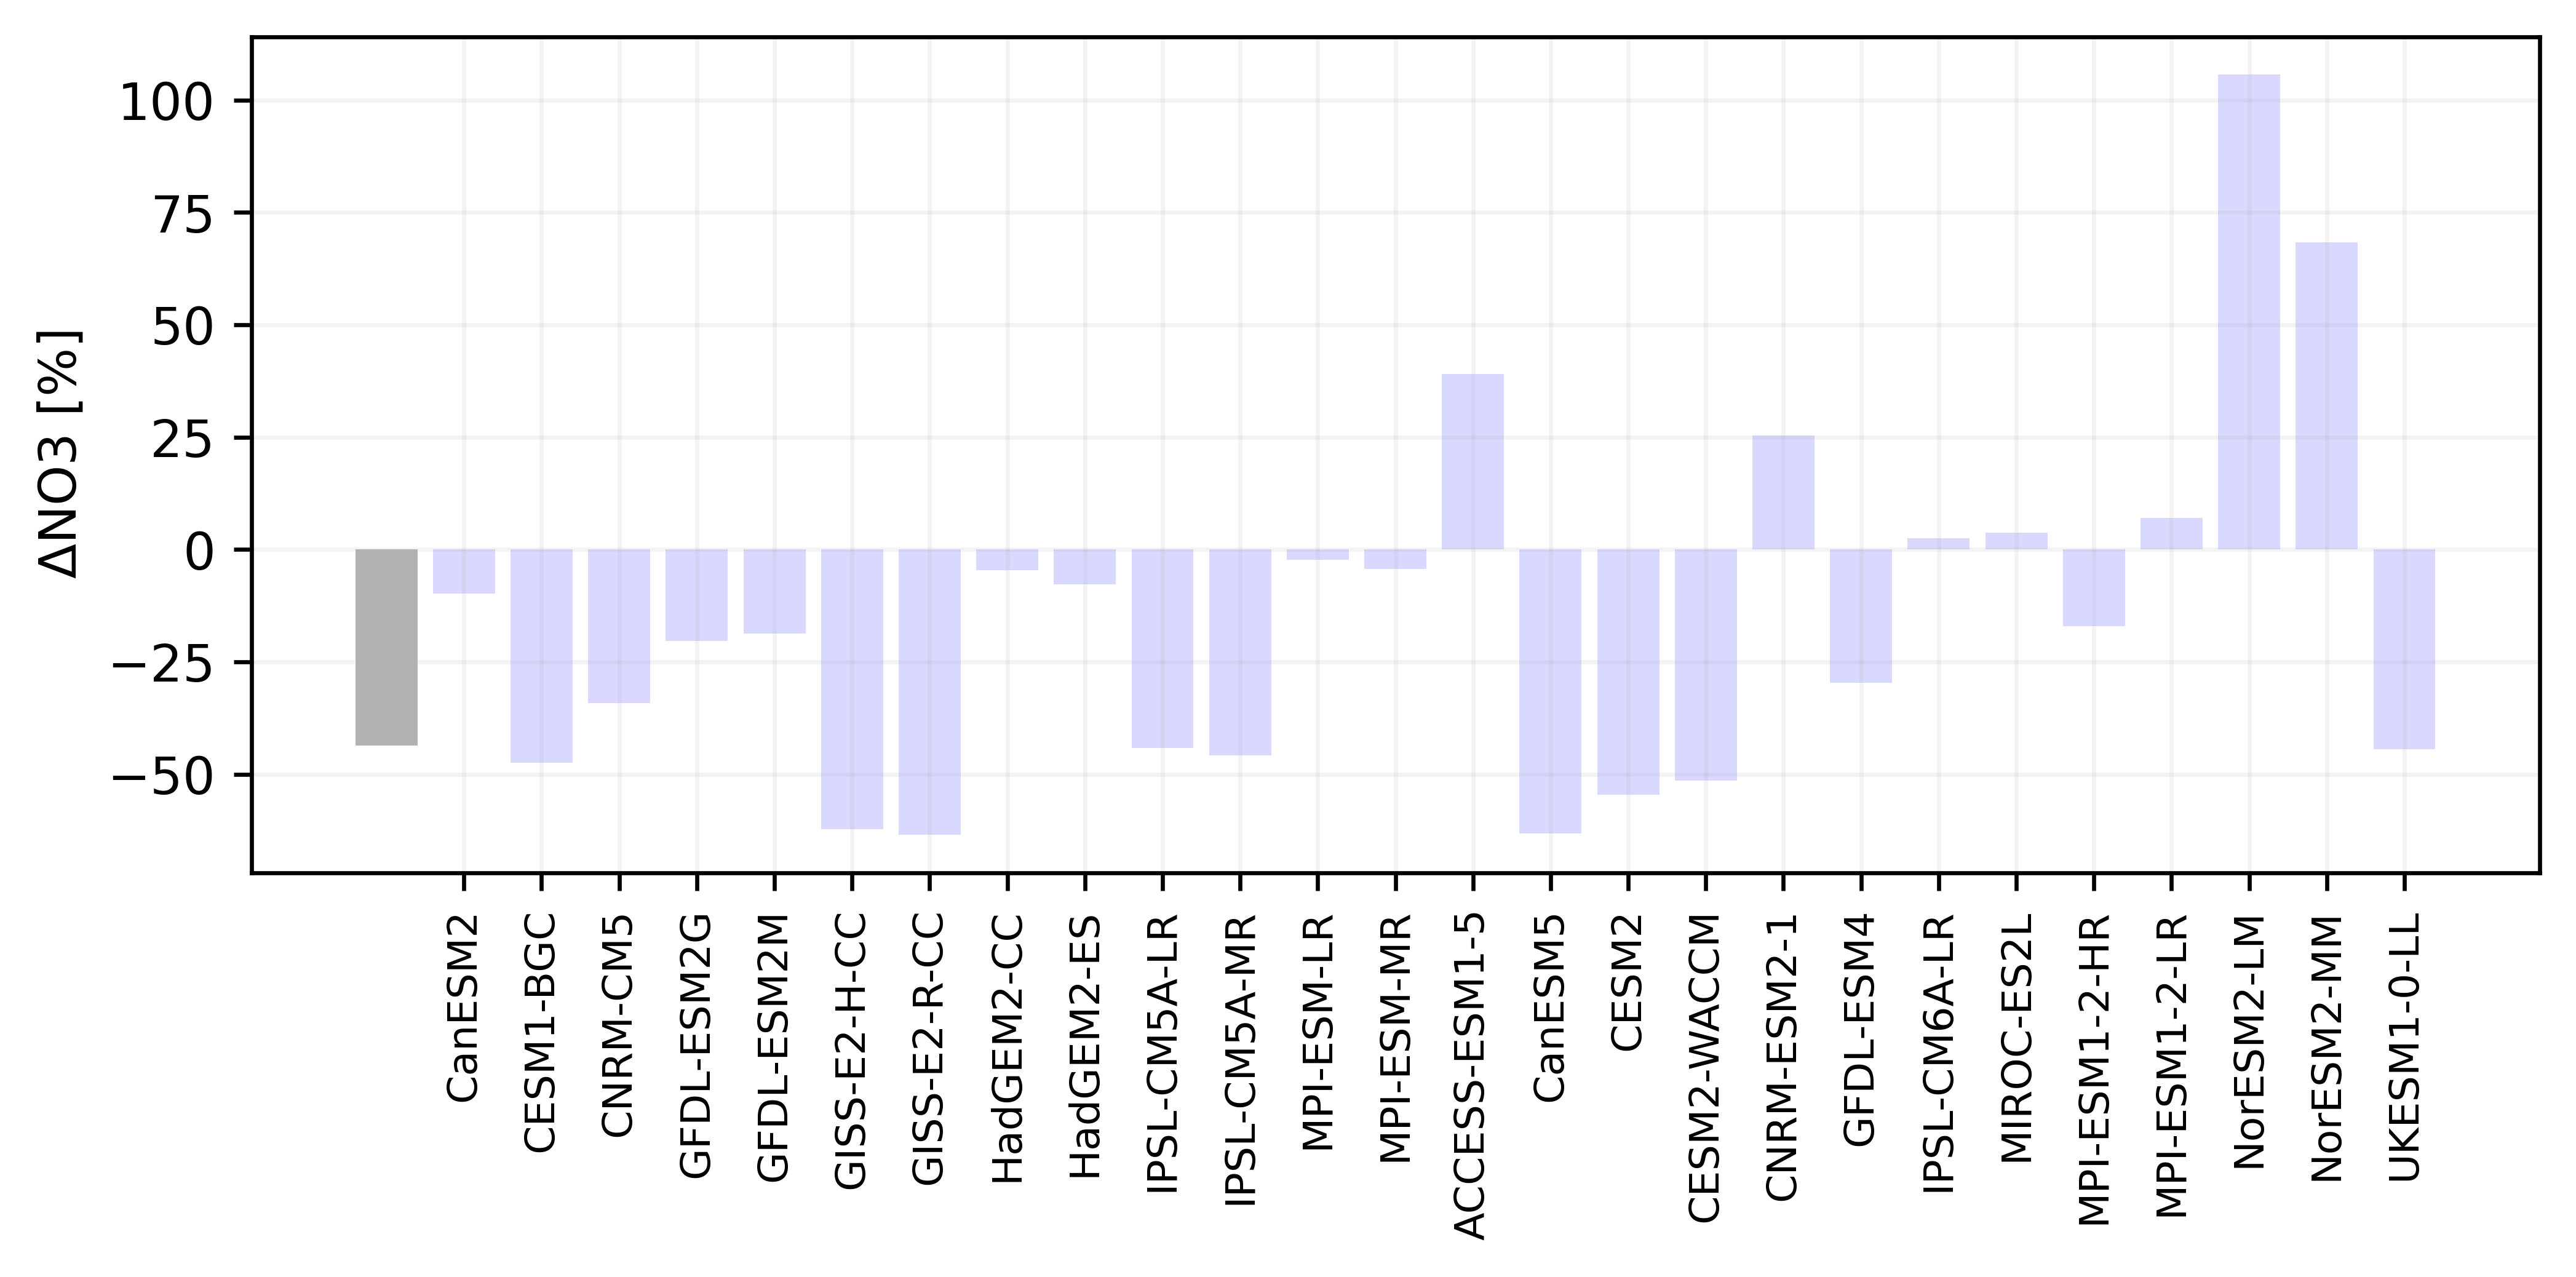

In [29]:
fig, axes = plt.subplots(1,1,figsize=(8,3))
tmp_x = np.linspace(1,26,26)
axes.bar(0,tmp_diff_NO3.mean("model_name"),color='grey',alpha=0.6)
axes.bar(np.linspace(1,26,26),tmp,color='b',alpha=0.15)
axes.grid(alpha=0.15)
axes.set_ylabel("$\Delta$NO3 [%]")
axes.set_xticks(tmp_x)
axes.set_xticklabels(tmp.model_name.values, 
                     rotation='vertical', fontsize=8)

[Text(1.0, 0, 'CanESM2'),
 Text(2.0, 0, 'CESM1-BGC'),
 Text(3.0, 0, 'CNRM-CM5'),
 Text(4.0, 0, 'GFDL-ESM2G'),
 Text(5.0, 0, 'GFDL-ESM2M'),
 Text(6.0, 0, 'GISS-E2-H-CC'),
 Text(7.0, 0, 'GISS-E2-R-CC'),
 Text(8.0, 0, 'HadGEM2-CC'),
 Text(9.0, 0, 'HadGEM2-ES'),
 Text(10.0, 0, 'IPSL-CM5A-LR'),
 Text(11.0, 0, 'IPSL-CM5A-MR'),
 Text(12.0, 0, 'MPI-ESM-LR'),
 Text(13.0, 0, 'MPI-ESM-MR'),
 Text(14.0, 0, 'ACCESS-ESM1-5'),
 Text(15.0, 0, 'CanESM5'),
 Text(16.0, 0, 'CESM2'),
 Text(17.0, 0, 'CESM2-WACCM'),
 Text(18.0, 0, 'CNRM-ESM2-1'),
 Text(19.0, 0, 'GFDL-ESM4'),
 Text(20.0, 0, 'IPSL-CM6A-LR'),
 Text(21.0, 0, 'MIROC-ES2L'),
 Text(22.0, 0, 'MPI-ESM1-2-HR'),
 Text(23.0, 0, 'MPI-ESM1-2-LR'),
 Text(24.0, 0, 'NorESM2-LM'),
 Text(25.0, 0, 'NorESM2-MM'),
 Text(26.0, 0, 'UKESM1-0-LL')]

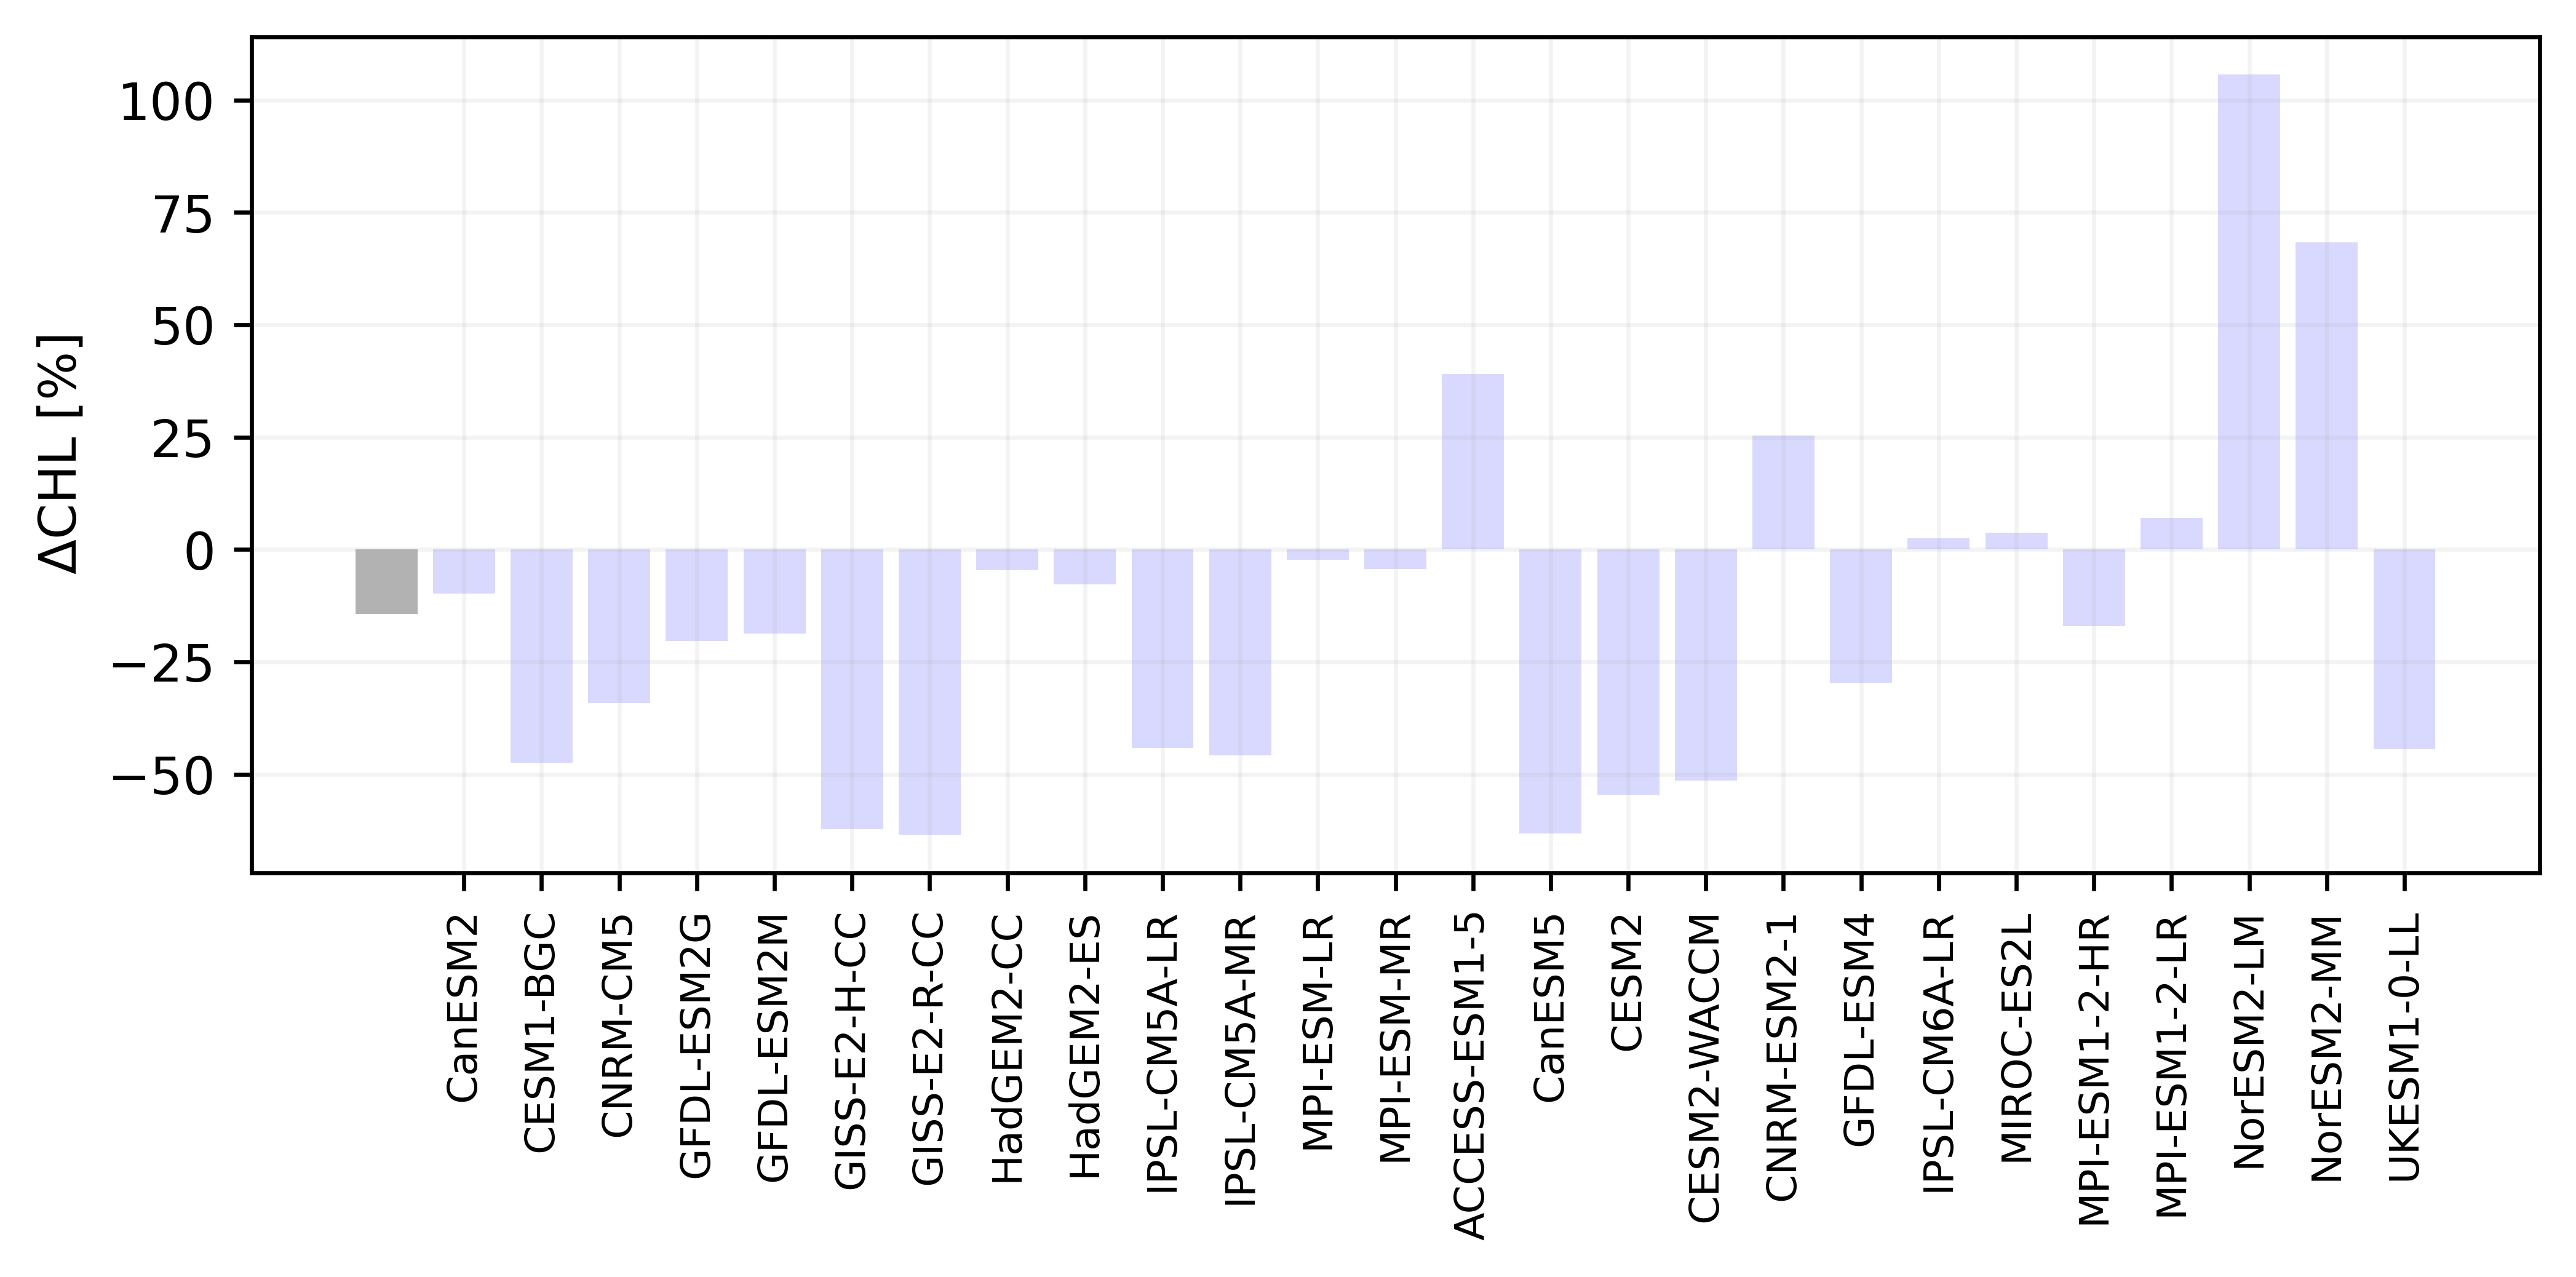

In [31]:
fig, axes = plt.subplots(1,1,figsize=(8,3))
tmp_x = np.linspace(1,26,26)
axes.bar(0,tmp_diff_CHL.mean("model_name"),color='grey',alpha=0.6)
axes.bar(np.linspace(1,26,26),tmp_diff_CHL,color='b',alpha=0.15)
axes.grid(alpha=0.15)
axes.set_ylabel("$\Delta$CHL [%]")
axes.set_xticks(tmp_x)
axes.set_xticklabels(tmp.model_name.values, 
                     rotation='vertical', fontsize=8)

[Text(1.0, 0, 'CanESM2'),
 Text(2.0, 0, 'CESM1-BGC'),
 Text(3.0, 0, 'CNRM-CM5'),
 Text(4.0, 0, 'GFDL-ESM2G'),
 Text(5.0, 0, 'GFDL-ESM2M'),
 Text(6.0, 0, 'GISS-E2-H-CC'),
 Text(7.0, 0, 'GISS-E2-R-CC'),
 Text(8.0, 0, 'HadGEM2-CC'),
 Text(9.0, 0, 'HadGEM2-ES'),
 Text(10.0, 0, 'IPSL-CM5A-LR'),
 Text(11.0, 0, 'IPSL-CM5A-MR'),
 Text(12.0, 0, 'MPI-ESM-LR'),
 Text(13.0, 0, 'MPI-ESM-MR'),
 Text(14.0, 0, 'ACCESS-ESM1-5'),
 Text(15.0, 0, 'CanESM5'),
 Text(16.0, 0, 'CESM2'),
 Text(17.0, 0, 'CESM2-WACCM'),
 Text(18.0, 0, 'CNRM-ESM2-1'),
 Text(19.0, 0, 'GFDL-ESM4'),
 Text(20.0, 0, 'IPSL-CM6A-LR'),
 Text(21.0, 0, 'MIROC-ES2L'),
 Text(22.0, 0, 'MPI-ESM1-2-HR'),
 Text(23.0, 0, 'MPI-ESM1-2-LR'),
 Text(24.0, 0, 'NorESM2-LM'),
 Text(25.0, 0, 'NorESM2-MM'),
 Text(26.0, 0, 'UKESM1-0-LL')]

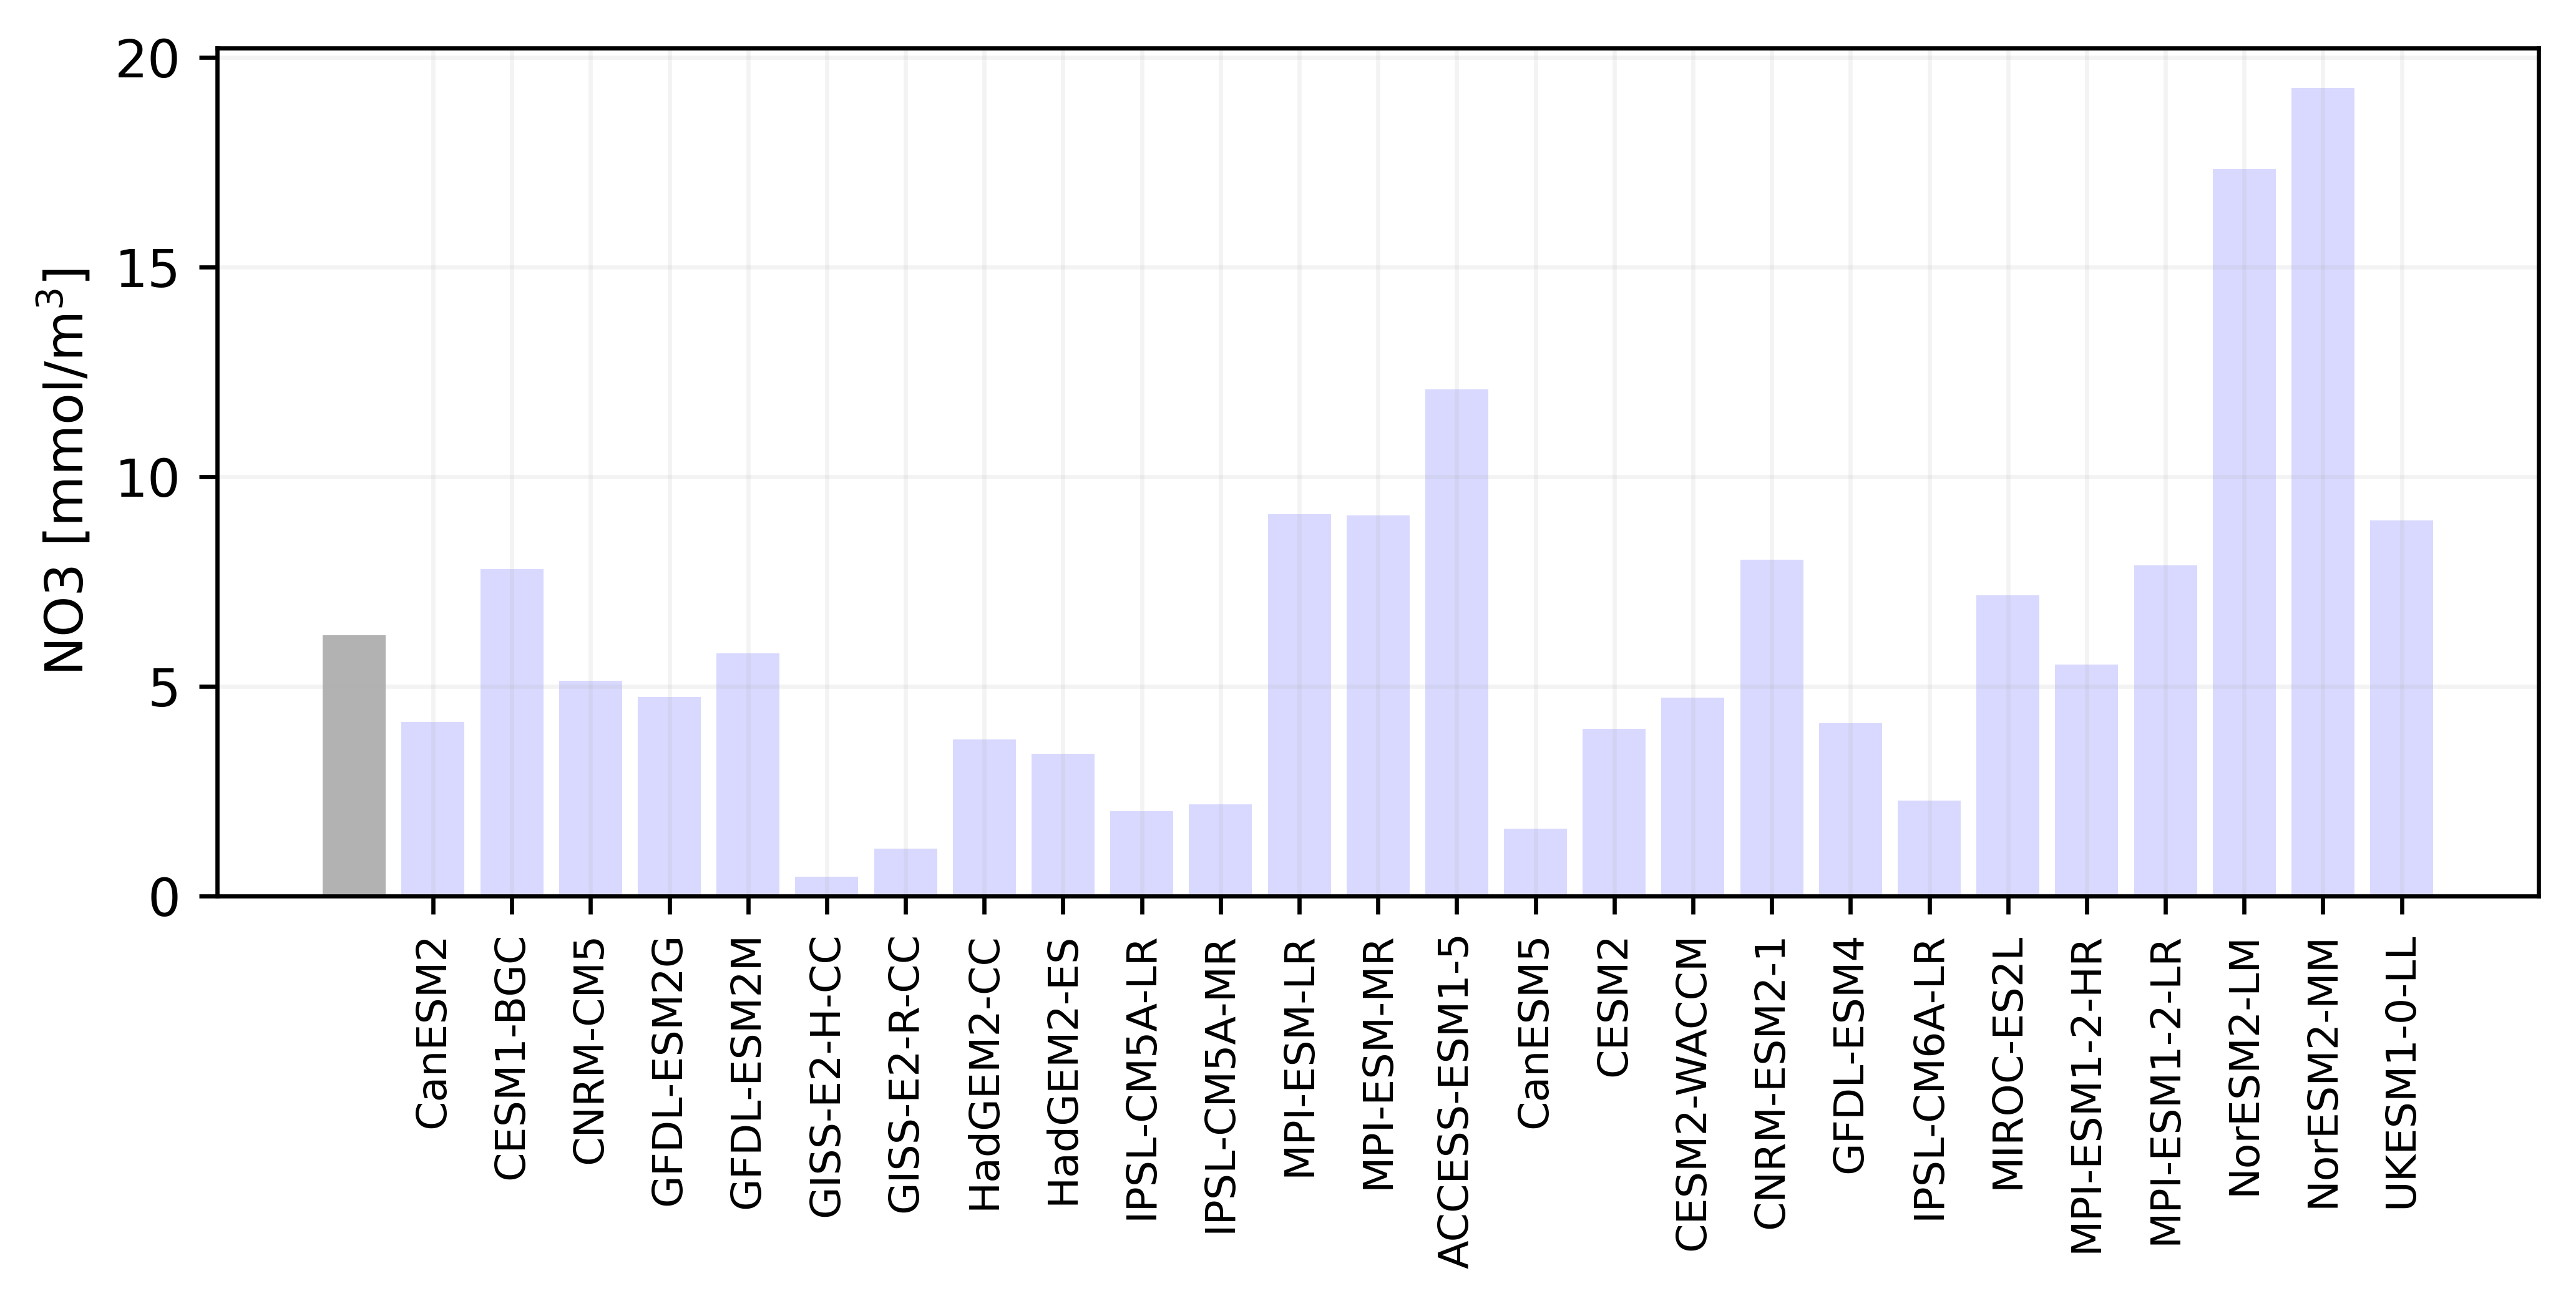

In [27]:
fig, axes = plt.subplots(1,1,figsize=(8,3))
tmp_x = np.linspace(1,26,26)
axes.bar(0,tmp_mean_NO3.mean("model_name"),color='grey',alpha=0.6)
axes.bar(np.linspace(1,26,26),tmp_mean_NO3,color='b',alpha=0.15)
axes.grid(alpha=0.15)
axes.set_ylabel("NO3 [mmol/m$^3$]")
axes.set_xticks(tmp_x)
axes.set_xticklabels(tmp.model_name.values, 
                     rotation='vertical', fontsize=8)